In [30]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cmap
from sklearn.metrics import (
    roc_curve,
    precision_score,
    recall_score,
)
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D

from io import BytesIO
from PIL import ImageDraw, Image, ImageFont
from collections import defaultdict

In [31]:
RMSD_THRESHOLD = 2
LDDT_PLI_THRESHOLD = 0.8
SIMILARITY_METRIC = "sucos_shape_pocket_qcov"
SIMILARITY_BINS = [0, 20, 30, 40, 50, 60, 70, 80, 100]
NUM_CCDS_THRESHOLD = 100

PALETTE = list(cmap.Colormap("tol:vibrant").iter_colors())

COLORS = {
    "af3": PALETTE[0],
    "protenix": PALETTE[2],
    "chai": PALETTE[3],
    "boltz": PALETTE[4],
    "best": PALETTE[-1],
}
SHAPES = {"af3": "o", "protenix": "s", "chai": "D", "boltz": "X", "best": "*"}
METHODS = ["af3", "protenix", "chai", "boltz"]
NAME_MAPPING = {
    "af3": "AlphaFold3",
    "protenix": "Protenix",
    "chai": "Chai-1",
    "boltz": "Boltz-1",
}
METRIC_NAMES = {
    "pocket_qcov": "Pocket\ncoverage",
    "sucos_shape": "Ligand\nSuCOS",
    "protein_fident_weighted_sum": "Protein\nsequence\nidentity",
    "tanimoto": "Ligand\nfingerprint\nsimilarity",
}

In [33]:
data_dir = Path("data")
figures_dir = data_dir / "figures"
figures_dir.mkdir(exist_ok=True)

In [34]:
annotated_df = pd.read_csv(data_dir / "annotations.csv")

In [35]:
full_datasets = {}
for method in METHODS:
    df = pd.read_csv(data_dir / "predictions" / f"{method}.csv", low_memory=False)
    keep_columns = [
        "target",
        "ligand_instance_chain",
        "lddt_pli",
        "rmsd",
        "lddt_lp",
        "bb_rmsd",
        "seed",
        "sample",
        "ranking_score",
        "ligand_is_proper",
        "prot_lig_chain_iptm_average_lddt_pli",
        "prot_lig_chain_iptm_min_lddt_pli",
        "prot_lig_chain_iptm_max_lddt_pli",
        "lig_prot_chain_iptm_average_lddt_pli",
        "lig_prot_chain_iptm_min_lddt_pli",
        "lig_prot_chain_iptm_max_lddt_pli",
        "prot_lig_chain_iptm_average_rmsd",
        "prot_lig_chain_iptm_min_rmsd",
        "prot_lig_chain_iptm_max_rmsd",
        "lig_prot_chain_iptm_average_rmsd",
        "lig_prot_chain_iptm_min_rmsd",
        "lig_prot_chain_iptm_max_rmsd",
    ]
    full_datasets[method] = (
        df[keep_columns].rename(columns={"target": "system_id"}).reset_index(drop=True)
    )

    full_datasets[method]["group_key"] = (
        full_datasets[method]["system_id"]
        + "__"
        + full_datasets[method]["ligand_instance_chain"]
    )
    full_datasets[method]["method"] = method
    full_datasets[method] = (
        full_datasets[method]
        .sort_values(by=["lddt_pli", "rmsd"], ascending=[False, True])
        .groupby(["group_key", "seed", "sample"])
        .head(1)
        .reset_index(drop=True)
    )

In [36]:
def pivot_df(df, annotated_df):
    df = df.pivot(
        index=[
            "group_key",
            "system_id",
            "ligand_is_proper",
            "ligand_instance_chain",
        ],
        columns="method",
        values=["lddt_pli", "rmsd", "lddt_lp", "bb_rmsd"],
    ).reset_index()
    df.columns = [f"{col[0]}_{col[1]}" if len(col[1]) else col[0] for col in df.columns]
    df = df[df["ligand_is_proper"].fillna(False)].reset_index(drop=True)
    merge_columns = [col for col in annotated_df.columns if col not in df.columns]
    df = df.merge(
        annotated_df[["group_key"] + merge_columns], on="group_key", how="left"
    )
    return df


top_dfs = {}
top_5_dfs = {}
best_5_dfs = {}
best_dfs = {}
worst_dfs = {}
rank_by = "ranking_score"
for m in full_datasets:
    top_dfs[m] = (
        full_datasets[m]
        .sort_values(by=rank_by, ascending=False)
        .groupby(["system_id", "ligand_instance_chain"])
        .head(1)
    )
    best_dfs[m] = (
        full_datasets[m]
        .sort_values(by="lddt_pli", ascending=False)
        .groupby(["system_id", "ligand_instance_chain"])
        .head(1)
    )
    worst_dfs[m] = (
        full_datasets[m]
        .sort_values(by="lddt_pli", ascending=True)
        .groupby(["system_id", "ligand_instance_chain"])
        .head(1)
    )
    top_5_dfs[m] = []
    all_top = (
        full_datasets[m]
        .sort_values(by=rank_by, ascending=False)
        .groupby(["group_key", "seed"])
        .head(1)
    )

    all_top["Rank"] = all_top.groupby("group_key")[rank_by].rank(
        ascending=False, method="first"
    )

    top_5_dfs[m] = []
    for rank in range(1, 6):
        df = all_top[all_top["Rank"] == rank]
        top_5_dfs[m].append(df)

    all_best = (
        full_datasets[m]
        .sort_values(by="lddt_pli", ascending=False)
        .groupby(["group_key", "seed"])
        .head(1)
    )
    all_best["Rank"] = all_best.groupby("group_key")["lddt_pli"].rank(
        ascending=False, method="first"
    )
    best_5_dfs[m] = []
    for rank in range(1, 6):
        df = all_best[all_best["Rank"] == rank]
        best_5_dfs[m].append(df)

results_df_top = pivot_df(pd.concat(top_dfs.values()), annotated_df)
results_df_best = pivot_df(pd.concat(best_dfs.values()), annotated_df)
results_df_worst = pivot_df(pd.concat(worst_dfs.values()), annotated_df)
results_df_top_5 = []
results_df_best_5 = []
for i in range(5):
    results_df_top_5.append(
        pivot_df(pd.concat([top_5_dfs[m][i] for m in top_5_dfs]), annotated_df)
    )
    results_df_best_5.append(
        pivot_df(pd.concat([best_5_dfs[m][i] for m in best_5_dfs]), annotated_df)
    )

dfs = {
    "top": results_df_top,
    "best": results_df_best,
    "worst": results_df_worst,
}
for i in range(5):
    dfs[f"top_5_{i + 1}"] = results_df_top_5[i]
    dfs[f"best_5_{i + 1}"] = results_df_best_5[i]

for m in dfs:
    dfs[m]["lddt_pli_max"] = np.nanmax(
        dfs[m][[f"lddt_pli_{m}" for m in METHODS]], axis=1
    )
    dfs[m]["rmsd_min"] = np.nanmin(dfs[m][[f"rmsd_{m}" for m in METHODS]], axis=1)
    dfs[m]["lddt_pli_average"] = np.nanmedian(
        dfs[m][[f"lddt_pli_{m}" for m in METHODS]], axis=1
    )
    dfs[m]["rmsd_average"] = np.nanmedian(
        dfs[m][[f"rmsd_{m}" for m in METHODS]], axis=1
    )

common_subset_dfs_all = {}
cluster_dfs_all = {}
for df in dfs:
    common_subset_dfs_all[df] = (
        dfs[df]
        .dropna(subset=[f"lddt_pli_{method}" for method in METHODS] + ["sucos_shape"])
        .reset_index(drop=True)
    )
    cluster_dfs_all[df] = (
        common_subset_dfs_all[df][
            common_subset_dfs_all[df]["ligand_is_proper"]
            & (common_subset_dfs_all[df]["sucos_shape"].notna())
        ]
        .sort_values(by=SIMILARITY_METRIC)
        .groupby("cluster")
        .head(1)
    )

In [37]:
print("Common subset:")
print("No. systems", common_subset_dfs_all["top"].system_id.nunique())
print("No. proper ligands", common_subset_dfs_all["top"]["ligand_is_proper"].sum())
print(
    "No. ligands",
    annotated_df[
        annotated_df["system_id"].isin(common_subset_dfs_all["top"]["system_id"])
    ].shape[0],
)

Common subset:
No. systems 2077
No. proper ligands 2311
No. ligands 3288


In [38]:
def plot_success_by_similarity(
    results_df,
    lddt_pli_column,
    rmsd_column,
    color="black",
    shape="o",
    similarity_metric="sucos_shape_pocket_qcov",
    rmsd_threshold=RMSD_THRESHOLD,
    lddt_pli_threshold=LDDT_PLI_THRESHOLD,
    similarity_bins=SIMILARITY_BINS,
    ax=None,
    label="",
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    bin_data = []
    bin_sizes = []
    bin_cis = []
    for i in range(len(similarity_bins) - 1):
        mask = (results_df[similarity_metric] >= similarity_bins[i]) & (
            results_df[similarity_metric] < similarity_bins[i + 1]
        )
        bin_sizes.append(len(results_df[mask]))

        mask_success = mask & results_df[lddt_pli_column].notna()
        success_vals = (results_df[mask_success][rmsd_column] < rmsd_threshold) & (
            results_df[mask_success][lddt_pli_column] > lddt_pli_threshold
        )
        bin_data.append(np.mean(success_vals.astype(float)) * 100)

        n_bootstrap = 1000
        bootstrap_means = []
        for _ in range(n_bootstrap):
            bootstrap_sample = np.random.choice(
                success_vals.astype(float), size=len(success_vals), replace=True
            )
            bootstrap_means.append(np.mean(bootstrap_sample) * 100)

        # Get 2.5th and 97.5th percentiles for 95% CI
        ci_lower = np.percentile(bootstrap_means, 2.5)
        ci_upper = np.percentile(bootstrap_means, 97.5)
        bin_cis.append((ci_lower, ci_upper))

    x = np.arange(len(bin_sizes))
    bin_cis = np.array(bin_cis)

    ax.plot(
        x,
        bin_data,
        marker=shape,
        markersize=10,
        linestyle="-",
        linewidth=2,
        color=color,
        label=label,
    )

    ax.fill_between(
        x,
        bin_cis[:, 0],
        bin_cis[:, 1],
        alpha=0.2,
        color=color,
    )

    ax.set_xlabel("Similarity to the training set", fontsize=12, fontweight="bold")
    ax.set_ylabel("Success Rate (%)", fontsize=12, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(
        [
            f"{similarity_bins[i]}-{similarity_bins[i + 1]}\n(n={bin_sizes[i]:,})"
            for i in range(len(similarity_bins) - 1)
        ],
        rotation=45,
        fontsize=12,
    )
    ax.set_ylim(0, 100)
    ax.tick_params(axis="y", labelsize=12)

    ax.grid(True, linestyle="--", alpha=0.7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="upper left", fontsize=10)

    return ax


def DrawMolsZoomed(
    mols, molsPerRow=3, subImgSize=(200, 200), legends=None, row_labels=None
):
    nRows = len(mols) // molsPerRow
    if len(mols) % molsPerRow:
        nRows += 1
    label_height = 40 if row_labels else 0
    fullSize = (
        molsPerRow * subImgSize[0],
        nRows * subImgSize[1] + nRows * label_height,
    )
    full_image = Image.new("RGBA", fullSize, "white")

    current_row = -1

    for ii, mol in enumerate(mols):
        if mol.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol)
        column = ii % molsPerRow
        row = ii // molsPerRow

        if row_labels and row != current_row:
            current_row = row
            label_img = Image.new(
                "RGBA", (molsPerRow * subImgSize[0], label_height), "white"
            )
            draw = ImageDraw.Draw(label_img)
            font = ImageFont.load_default(size=20)
            draw.text(
                (10, 5),
                row_labels[row],
                fill=(0, 0, 0),
                font=font,
            )
            full_image.paste(label_img, box=(0, row * (subImgSize[1] + label_height)))

        offset = (
            column * subImgSize[0],
            row * (subImgSize[1] + label_height) + label_height,
        )
        d2d = rdMolDraw2D.MolDraw2DCairo(subImgSize[0], subImgSize[1])
        legend = legends[ii] if legends is not None else None
        d2d.DrawMolecule(mol, legend=legend)
        d2d.FinishDrawing()
        sub = Image.open(BytesIO(d2d.GetDrawingText()))
        full_image.paste(sub, box=offset)
    return full_image


def make_one_plot(
    df,
    ax,
    title,
    similarity_metric=SIMILARITY_METRIC,
    similarity_bins=SIMILARITY_BINS,
    lddt_pli_threshold=LDDT_PLI_THRESHOLD,
    rmsd_threshold=RMSD_THRESHOLD,
    methods=METHODS,
):
    df = df[df["sucos_shape"].notna() & df["ligand_is_proper"]].reset_index(drop=True)
    for method in methods:
        plot_success_by_similarity(
            df,
            ax=ax,
            lddt_pli_column=f"lddt_pli_{method}",
            rmsd_column=f"rmsd_{method}",
            label=NAME_MAPPING[method],
            shape=SHAPES[method],
            color=COLORS[method],
            rmsd_threshold=rmsd_threshold,
            lddt_pli_threshold=lddt_pli_threshold,
            similarity_metric=similarity_metric,
            similarity_bins=similarity_bins,
        )

    plot_success_by_similarity(
        df,
        ax=ax,
        lddt_pli_column="lddt_pli_max",
        rmsd_column="rmsd_min",
        label="Best",
        shape="*",
        color=COLORS["best"],
        rmsd_threshold=rmsd_threshold,
        lddt_pli_threshold=lddt_pli_threshold,
        similarity_metric=similarity_metric,
        similarity_bins=similarity_bins,
    )
    ax.text(0.015, 0.95, title, transform=ax.transAxes, fontsize=14, fontweight="bold")
    ax.legend(loc="lower right", frameon=False)


def make_main_figure(
    df,
    cluster_df,
    filename,
    accuracy_metric,
    similarity_metric=SIMILARITY_METRIC,
    num_ccds_threshold=NUM_CCDS_THRESHOLD,
    similarity_bins=SIMILARITY_BINS,
    log=False,
    lddt_pli_threshold=LDDT_PLI_THRESHOLD,
    rmsd_threshold=RMSD_THRESHOLD,
    methods=METHODS,
    suffix=" common subset",
):
    fig = plt.figure(figsize=(20, 12))

    gs = plt.GridSpec(
        2,
        3,
        hspace=0.3,
        wspace=0.2,
    )

    ax1 = fig.add_subplot(gs[0, 0])

    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, :])

    make_one_plot(
        df,
        ax1,
        title=f"A) All{suffix}",
        similarity_metric=similarity_metric,
        similarity_bins=similarity_bins,
        lddt_pli_threshold=lddt_pli_threshold,
        rmsd_threshold=rmsd_threshold,
        methods=methods,
    )
    make_one_plot(
        df[df["num_training_systems_with_similar_ccds"] < num_ccds_threshold],
        ax2,
        title="B) Filtered",
        similarity_metric=similarity_metric,
        similarity_bins=similarity_bins,
        lddt_pli_threshold=lddt_pli_threshold,
        rmsd_threshold=rmsd_threshold,
        methods=methods,
    )
    make_one_plot(
        cluster_df[
            cluster_df["num_training_systems_with_similar_ccds"] < num_ccds_threshold
        ],
        ax3,
        title="C) Clustered filtered",
        similarity_metric=similarity_metric,
        similarity_bins=similarity_bins,
        lddt_pli_threshold=lddt_pli_threshold,
        rmsd_threshold=rmsd_threshold,
        methods=methods,
    )
    ax4.text(
        0.005,
        0.95,
        f"D) {accuracy_metric.upper().replace('_', '-')} distribution of all{suffix}",
        transform=ax4.transAxes,
        fontsize=14,
        fontweight="bold",
    )
    plot_data = []
    cluster_representatives = set(cluster_df["group_key"])
    df = df[df["ligand_is_proper"] & df["sucos_shape"].notna()].reset_index(drop=True)
    for i in range(len(similarity_bins) - 1):
        mask = (df[similarity_metric] >= similarity_bins[i]) & (
            df[similarity_metric] < similarity_bins[i + 1]
        )
        bin_size = mask.sum()

        bin_data = {
            "bin_range": f"{similarity_bins[i]}-{similarity_bins[i + 1]}",
            "n_samples": bin_size,
            "position": i,
        }

        all_values = []
        for method in methods:
            values = df[mask & (~df["group_key"].isin(cluster_representatives))][
                f"{accuracy_metric}_{method}"
            ].dropna()
            representative_values = df[
                mask & (df["group_key"].isin(cluster_representatives))
            ][f"{accuracy_metric}_{method}"].dropna()
            if log:
                values = np.log10(values)
                representative_values = np.log10(representative_values)
            bin_data[method] = np.concatenate([values, representative_values])
            bin_data[f"{method}_rest"] = values
            bin_data[f"{method}_representative"] = representative_values
            all_values.extend(values)
            all_values.extend(representative_values)
        bin_data["mean"] = np.mean(all_values)
        bin_data["median"] = np.median(all_values)
        plot_data.append(bin_data)

    for i, bin_data in enumerate(plot_data):
        pos = i + 1
        parts = ax4.violinplot(
            np.concatenate([bin_data[method] for method in methods]),
            positions=[pos],
            showmeans=False,
            showmedians=False,
            showextrema=False,
        )
        for pc in parts["bodies"]:
            pc.set_facecolor("gray")
            pc.set_alpha(0.3)
            pc.set_edgecolor("gray")

        method_offsets = {
            method: pos + (j - len(methods) / 2 + 0.5) * 0.2
            for j, method in enumerate(methods)
        }

        for method in methods:
            x_jitter = np.random.normal(0, 0.02, size=len(bin_data[f"{method}_rest"]))
            ax4.scatter(
                [method_offsets[method] + xj for xj in x_jitter],
                bin_data[f"{method}_rest"],
                color=COLORS[method],
                alpha=0.4,
                s=5,
                marker=SHAPES[method],
            )

            x_jitter = np.random.normal(
                0, 0.02, size=len(bin_data[f"{method}_representative"])
            )
            ax4.scatter(
                [method_offsets[method] + xj for xj in x_jitter],
                bin_data[f"{method}_representative"],
                color=COLORS[method],
                alpha=1,
                s=10,
                marker=SHAPES[method],
                edgecolor="#7c7c7d",
                linewidth=0.5,
            )
        ax4.plot(
            pos,
            bin_data["median"],
            "s",
            color=COLORS["best"],
            markersize=10,
            label="Median" if i == 0 else "",
            markeredgecolor="black",
            markeredgewidth=1,
        )
        ax4.plot(
            pos,
            bin_data["mean"],
            "D",
            color=COLORS["best"],
            markersize=8,
            label="Mean" if i == 0 else "",
            markeredgecolor="black",
            markeredgewidth=1,
        )
    ax4.grid(True, axis="y", linestyle="--", alpha=0.7)
    ax4.set_xlabel("Similarity to the training set", fontsize=12, fontweight="bold")
    ax4.set_ylabel(
        f"{accuracy_metric.upper().replace('_', '-')}", fontsize=12, fontweight="bold"
    )
    ax4.set_xticks([i for i in range(len(plot_data) + 1)])
    ax4.set_xticklabels(
        [""] + [f"{d['bin_range']}\n(n={d['n_samples']})" for d in plot_data],
        rotation=0,
    )
    threshold = lddt_pli_threshold if accuracy_metric == "lddt_pli" else rmsd_threshold
    label = threshold if accuracy_metric == "lddt_pli" else f"{threshold}Å"
    if log:
        threshold = np.log10(threshold)
    ax4.axhline(
        y=threshold, color="#7c7c7d", linestyle="--", alpha=0.5, linewidth=2, zorder=-1
    )
    ax4.text(
        0.25,
        threshold + 0.03,
        label,
        verticalalignment="center",
        horizontalalignment="right",
        fontsize=12,
        fontweight="bold",
        color="#7c7c7d",
    )
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            color=COLORS[method],
            label=NAME_MAPPING[method],
            marker=SHAPES[method],
            markersize=8,
            linestyle="none",
        )
        for method in METHODS
    ]
    legend_elements.extend(
        [
            plt.Line2D(
                [0],
                [0],
                color=COLORS["best"],
                marker="s",
                label="Median",
                markersize=8,
                linestyle="none",
            ),
            plt.Line2D(
                [0],
                [0],
                marker="D",
                color=COLORS["best"],
                label="Mean",
                markersize=8,
                linestyle="none",
            ),
        ]
    )
    ax4.legend(handles=legend_elements, loc="lower left", frameon=False)

    if log:
        ax4.set_yticklabels([f"{10**x:.2f}" for x in ax4.get_yticks()])
    ax4.set_xlim(-0.05, len(plot_data) + 0.5)

    plt.savefig(figures_dir / filename, dpi=300)


def make_one_plot_binned(df, ax, title, column, bins, column_name, fontsize=12):
    bin_data = defaultdict(list)
    bin_sizes = []
    df = df[df["ligand_is_proper"] & df["sucos_shape"].notna()].reset_index(drop=True)
    for i in range(len(bins) - 1):
        mask = (df[column] >= bins[i]) & (df[column] < bins[i + 1])
        bin_sizes.append(len(df[mask]))
        for method in METHODS:
            mask_inner = mask & (df[f"rmsd_{method}"].notna())
            b = (df[mask_inner][f"rmsd_{method}"] < RMSD_THRESHOLD) & (
                df[mask_inner][f"lddt_pli_{method}"] > LDDT_PLI_THRESHOLD
            )
            bin_data[method].append(b.mean() * 100)
        mask_inner = mask & (df["rmsd_min"].notna())
        b = (df[mask_inner]["rmsd_min"] < RMSD_THRESHOLD) & (
            df[mask_inner]["lddt_pli_max"] > LDDT_PLI_THRESHOLD
        )
        bin_data["best"].append(b.mean() * 100)

    x = np.arange(len(bin_sizes))
    n_bootstrap = 1000
    bootstrap_data = defaultdict(list)

    for method in METHODS:
        for i in range(len(bins) - 1):
            mask = (df[column] >= bins[i]) & (df[column] < bins[i + 1])
            mask_inner = mask & (df[f"rmsd_{method}"].notna())
            data = df[mask_inner]
            boot_means = []

            for _ in range(n_bootstrap):
                boot_sample = data.sample(n=len(data), replace=True)
                b = (boot_sample[f"rmsd_{method}"] < RMSD_THRESHOLD) & (
                    boot_sample[f"lddt_pli_{method}"] > LDDT_PLI_THRESHOLD
                )
                boot_means.append(b.mean() * 100)

            ci_lower = np.percentile(boot_means, 2.5)
            ci_upper = np.percentile(boot_means, 97.5)
            bootstrap_data[method].append((ci_lower, ci_upper))
    for i in range(len(bins) - 1):
        mask = (df[column] >= bins[i]) & (df[column] < bins[i + 1])
        mask_inner = mask & (df["rmsd_min"].notna())
        data = df[mask_inner]
        boot_means = []

        for _ in range(n_bootstrap):
            boot_sample = data.sample(n=len(data), replace=True)
            b = (boot_sample["rmsd_min"] < RMSD_THRESHOLD) & (
                boot_sample["lddt_pli_max"] > LDDT_PLI_THRESHOLD
            )
            boot_means.append(b.mean() * 100)

        ci_lower = np.percentile(boot_means, 2.5)
        ci_upper = np.percentile(boot_means, 97.5)
        bootstrap_data["best"].append((ci_lower, ci_upper))

    for method in METHODS:
        ci_lower = [ci[0] for ci in bootstrap_data[method]]
        ci_upper = [ci[1] for ci in bootstrap_data[method]]

        ax.fill_between(x, ci_lower, ci_upper, alpha=0.2, color=COLORS[method])
        ax.plot(
            x,
            bin_data[method],
            marker=SHAPES[method],
            markersize=10,
            linestyle="-",
            linewidth=2,
            label=NAME_MAPPING[method],
            color=COLORS[method],
        )
    ci_lower = [ci[0] for ci in bootstrap_data["best"]]
    ci_upper = [ci[1] for ci in bootstrap_data["best"]]

    ax.fill_between(x, ci_lower, ci_upper, alpha=0.2, color=COLORS["best"])
    ax.plot(
        x,
        bin_data["best"],
        marker=SHAPES["best"],
        markersize=10,
        linestyle="-",
        linewidth=2,
        label="Best",
        color=COLORS["best"],
    )

    ax.set_xlabel(column_name, fontsize=12, fontweight="bold")
    ax.set_ylabel("Success Rate (%)", fontsize=12, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(
        [
            f"{bins[i]}-{bins[i + 1]}\n(n={bin_sizes[i]:,})"
            for i in range(len(bins) - 1)
        ],
        rotation=45,
        fontsize=fontsize,
    )
    ax.set_ylim(0, 100)
    ax.tick_params(axis="y", labelsize=12)

    ax.grid(True, linestyle="--", alpha=0.7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.text(0.015, 0.95, title, transform=ax.transAxes, fontsize=14, fontweight="bold")
    ax.legend(loc="lower right", frameon=False)


def other_metrics(
    df,
    cluster_df,
    filename,
    metric_names=METRIC_NAMES,
    similarity_bins=SIMILARITY_BINS,
    similarity_metric=SIMILARITY_METRIC,
):
    fig, ax = plt.subplots(2, 1, figsize=(20, 15), height_ratios=[1.5, 1])
    ax1, ax4 = ax

    ax1.text(0.005, 0.95, "A", transform=ax1.transAxes, fontsize=14, fontweight="bold")
    ax4.text(0.005, 0.95, "B", transform=ax4.transAxes, fontsize=14, fontweight="bold")
    df = df[df["ligand_is_proper"] & df["sucos_shape"].notna()].reset_index(drop=True)
    colors = list(cmap.Colormap("tol:bright").iter_colors())
    plot_data = []
    log = False
    cluster_representatives = set(cluster_df["group_key"])
    for i in range(len(similarity_bins) - 1):
        mask = (df[similarity_metric] >= similarity_bins[i]) & (
            df[similarity_metric] <= similarity_bins[i + 1]
        )
        bin_size = mask.sum()

        bin_data = {
            "bin_range": f"{similarity_bins[i]}-{similarity_bins[i + 1]}",
            "n_samples": bin_size,
            "position": i,
        }

        for metric in metric_names:
            bin_data[metric] = df[mask][metric].dropna()
            bin_data[f"{metric}_rest"] = df[
                mask & (df["group_key"].isin(cluster_representatives))
            ][metric].dropna()
            bin_data[f"{metric}_representative"] = df[
                mask & (df["group_key"].isin(cluster_representatives))
            ][metric].dropna()
            bin_data[f"{metric}_mean"] = np.mean(bin_data[metric])
            bin_data[f"{metric}_median"] = np.median(bin_data[metric])

        plot_data.append(bin_data)

    space_between_metrics = 0.3
    space_between_bins = 0.5
    xtick_positions = []
    for i, bin_data in enumerate(plot_data):
        pos = i
        for j, metric in enumerate(metric_names):
            offset = j * space_between_metrics + pos * space_between_bins
            parts = ax1.violinplot(
                [bin_data[metric]],
                positions=[pos + offset],
                showmeans=False,
                showmedians=False,
                showextrema=False,
            )
            for pc in parts["bodies"]:
                pc.set_facecolor(colors[j])
                pc.set_alpha(0.3)
                pc.set_edgecolor(colors[j])
            x_jitter = np.random.normal(0, 0.05, size=len(bin_data[f"{metric}_rest"]))
            ax1.scatter(
                [pos + offset + xj for xj in x_jitter],
                bin_data[f"{metric}_rest"],
                color=colors[j],
                alpha=0.4,
                s=5,
                marker="o",
            )
            x_jitter = np.random.normal(
                0, 0.05, size=len(bin_data[f"{metric}_representative"])
            )
            ax1.scatter(
                [pos + offset + xj for xj in x_jitter],
                bin_data[f"{metric}_representative"],
                color=colors[j],
                alpha=1,
                s=10,
                marker="o",
                edgecolor="#7c7c7d",
                linewidth=0.5,
            )
            ax1.plot(
                pos + offset,
                bin_data[f"{metric}_median"],
                "s",
                color=colors[j],
                markersize=10,
                markeredgecolor="black",
                markeredgewidth=1,
            )
            ax1.plot(
                pos + offset,
                bin_data[f"{metric}_mean"],
                "D",
                color=colors[j],
                markersize=8,
                markeredgecolor="black",
                markeredgewidth=1,
            )
        xtick_positions.append(
            pos + offset - space_between_metrics * len(metric_names) / 2
        )

    ax1.grid(True, axis="y", linestyle="--", alpha=0.7)
    ax1.set_xlabel("Similarity to the training set", fontsize=12, fontweight="bold")
    ax1.set_ylabel("Metric Value", fontsize=12, fontweight="bold")
    ax1.set_xticks(xtick_positions)
    ax1.set_xticklabels(
        [f"{d['bin_range']}\n(n={d['n_samples']})" for d in plot_data],
        rotation=0,
        ha="center",
    )
    metric_legend_elements = []
    for j, metric in enumerate(metric_names):
        metric_legend_elements.append(
            plt.Line2D(
                [0],
                [0],
                color=colors[j],
                label=metric_names[metric],
                marker="o",
                markersize=8,
                linestyle="none",
            )
        )
    stat_legend_elements = [
        plt.Line2D(
            [0],
            [0],
            color=COLORS["best"],
            marker="s",
            label="Median",
            markersize=8,
            linestyle="none",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="D",
            color=COLORS["best"],
            label="Mean",
            markersize=8,
            linestyle="none",
        ),
    ]
    ax1.legend(
        handles=metric_legend_elements + stat_legend_elements,
        loc="lower left",
        frameon=False,
    )

    if log:
        ax1.set_yticklabels([f"{10**x:.2f}" for x in ax1.get_yticks()])
    ax1.set_xlim(-1.1, max(xtick_positions) + 1)

    score = "lddt_lp"
    log = False
    plot_data = []
    for i in range(len(similarity_bins) - 1):
        mask = (df[similarity_metric] >= similarity_bins[i]) & (
            df[similarity_metric] <= similarity_bins[i + 1]
        )
        bin_size = mask.sum()

        bin_data = {
            "bin_range": f"{similarity_bins[i]}-{similarity_bins[i + 1]}",
            "n_samples": bin_size,
            "position": i,
        }

        # Store per-method values for scatter plots
        all_values = []
        for method in METHODS:
            values = df[mask & (~df["group_key"].isin(cluster_representatives))][
                f"{score}_{method}"
            ].dropna()
            representative_values = df[
                mask & (df["group_key"].isin(cluster_representatives))
            ][f"{score}_{method}"].dropna()
            if log:
                values = np.log10(values)
                representative_values = np.log10(representative_values)
            bin_data[method] = np.concatenate([values, representative_values])
            bin_data[f"{method}_rest"] = values
            bin_data[f"{method}_representative"] = representative_values
            all_values.extend(values)
            all_values.extend(representative_values)
        # Calculate overall statistics
        bin_data["mean"] = np.mean(all_values)
        bin_data["median"] = np.median(all_values)
        plot_data.append(bin_data)

    # Plot violins in bottom plot
    for i, bin_data in enumerate(plot_data):
        pos = i

        # Single violin plot
        parts = ax4.violinplot(
            np.concatenate([bin_data[method] for method in METHODS]),
            positions=[pos],
            showmeans=False,
            showmedians=False,
            showextrema=False,
        )

        # Style violin - use neutral color
        for pc in parts["bodies"]:
            pc.set_facecolor("gray")
            pc.set_alpha(0.3)
            pc.set_edgecolor("gray")
        method_offsets = {
            method: pos + (j - len(METHODS) / 2 + 0.5) * 0.2
            for j, method in enumerate(METHODS)
        }

        for method in METHODS:
            x_jitter = np.random.normal(0, 0.02, size=len(bin_data[f"{method}_rest"]))

            ax4.scatter(
                [method_offsets[method] + xj for xj in x_jitter],
                bin_data[f"{method}_rest"],
                color=COLORS[method],
                alpha=0.4,
                s=5,
                marker=SHAPES[method],
            )

            x_jitter = np.random.normal(
                0, 0.02, size=len(bin_data[f"{method}_representative"])
            )

            ax4.scatter(
                [method_offsets[method] + xj for xj in x_jitter],
                bin_data[f"{method}_representative"],
                color=COLORS[method],
                alpha=1,
                s=10,
                marker=SHAPES[method],
                edgecolor="#7c7c7d",
                linewidth=0.5,
            )
        ax4.plot(
            pos,
            bin_data["median"],
            "s",
            color=COLORS["best"],
            markersize=10,
            label="Median" if i == 0 else "",
            markeredgecolor="black",
            markeredgewidth=1,
        )
        ax4.plot(
            pos,
            bin_data["mean"],
            "D",
            color=COLORS["best"],
            markersize=8,
            label="Mean" if i == 0 else "",
            markeredgecolor="black",
            markeredgewidth=1,
        )
    ax4.grid(True, axis="y", linestyle="--", alpha=0.7)
    ax4.set_xlabel("Similarity to the training set", fontsize=12, fontweight="bold")
    ax4.set_ylabel(
        f"{score.upper().replace('_', '-').replace('BB-', 'Pocket Backbone ')}",
        fontsize=12,
        fontweight="bold",
    )
    ax4.set_xticks([i for i in range(len(plot_data))])
    ax4.set_xticklabels(
        [f"{d['bin_range']}\n(n={d['n_samples']})" for d in plot_data],
        rotation=0,
    )
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            color=COLORS[method],
            label=NAME_MAPPING[method],
            marker=SHAPES[method],
            markersize=8,
            linestyle="none",
        )
        for method in METHODS
    ]
    legend_elements.extend(
        [
            plt.Line2D(
                [0],
                [0],
                color=COLORS["best"],
                marker="s",
                label="Median",
                markersize=8,
                linestyle="none",
            ),
            plt.Line2D(
                [0],
                [0],
                marker="D",
                color=COLORS["best"],
                label="Mean",
                markersize=8,
                linestyle="none",
            ),
        ]
    )
    ax4.legend(handles=legend_elements, loc="lower left", frameon=False)
    if log:
        ax4.set_yticklabels([f"{10**x:.2f}" for x in ax4.get_yticks()])
    ax4.set_xlim(-0.95, len(plot_data) - 0.3)
    plt.savefig(figures_dir / filename, dpi=300)


# Results

## Figure 1

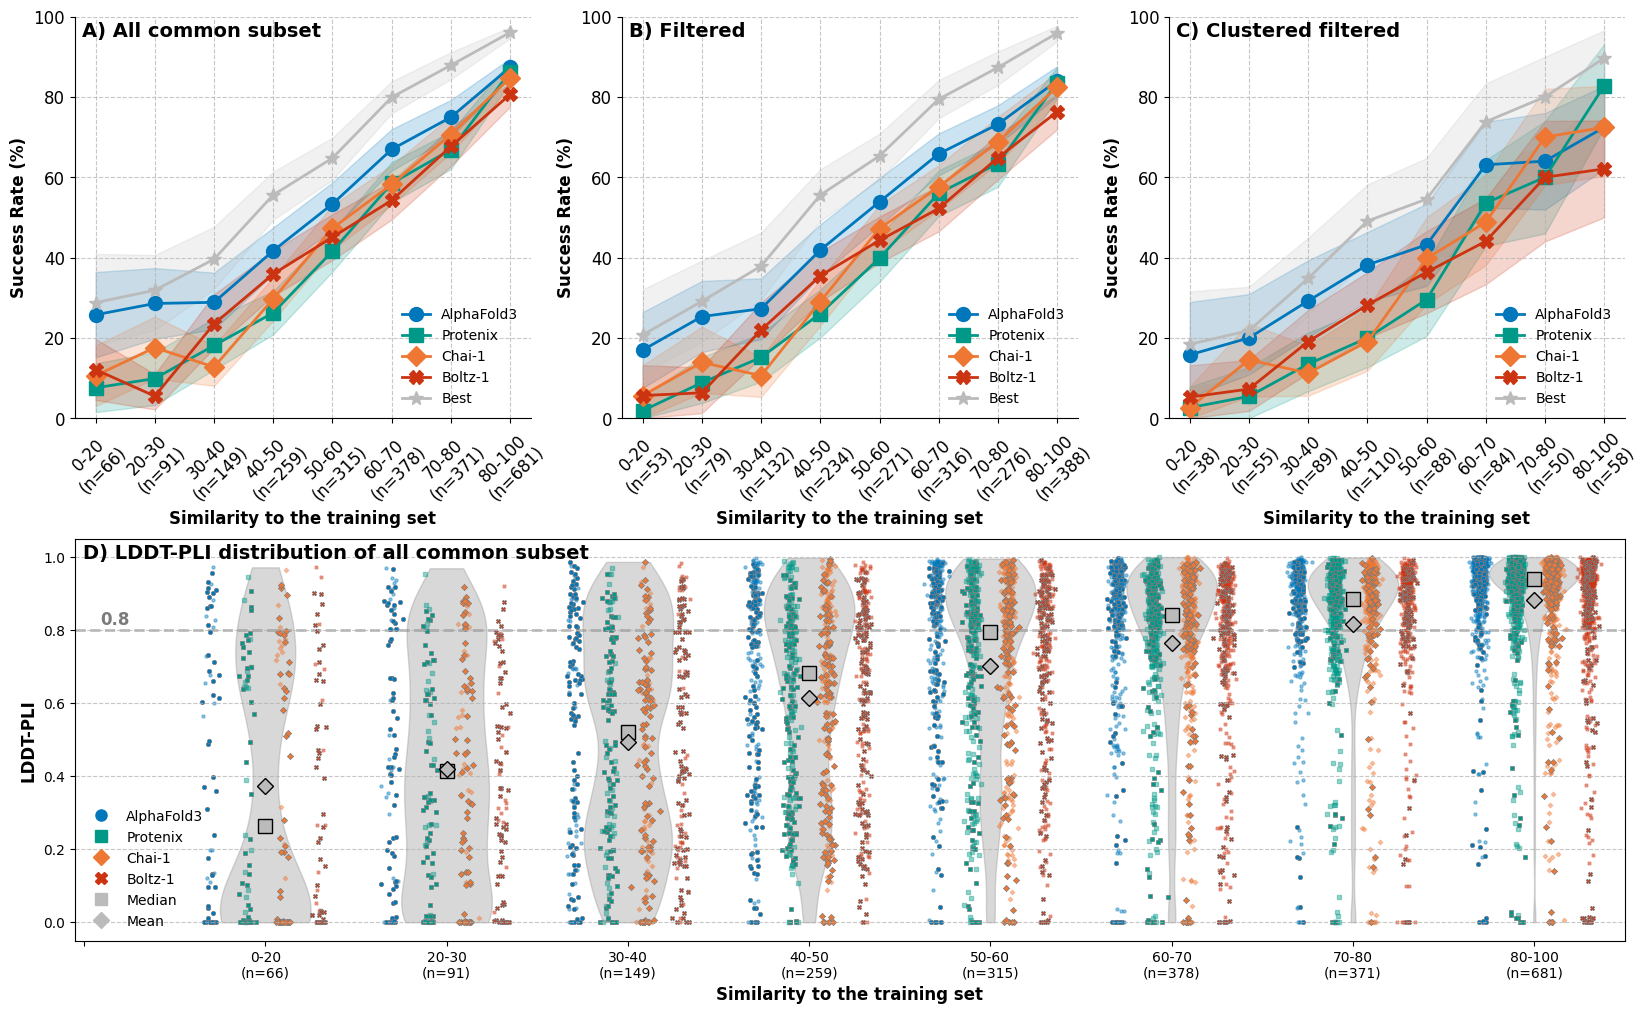

In [10]:
make_main_figure(
    common_subset_dfs_all["top"],
    cluster_dfs_all["top"],
    "fig_1.png",
    "lddt_pli",
    methods=METHODS,
)

## Supplementary Figure 1-1

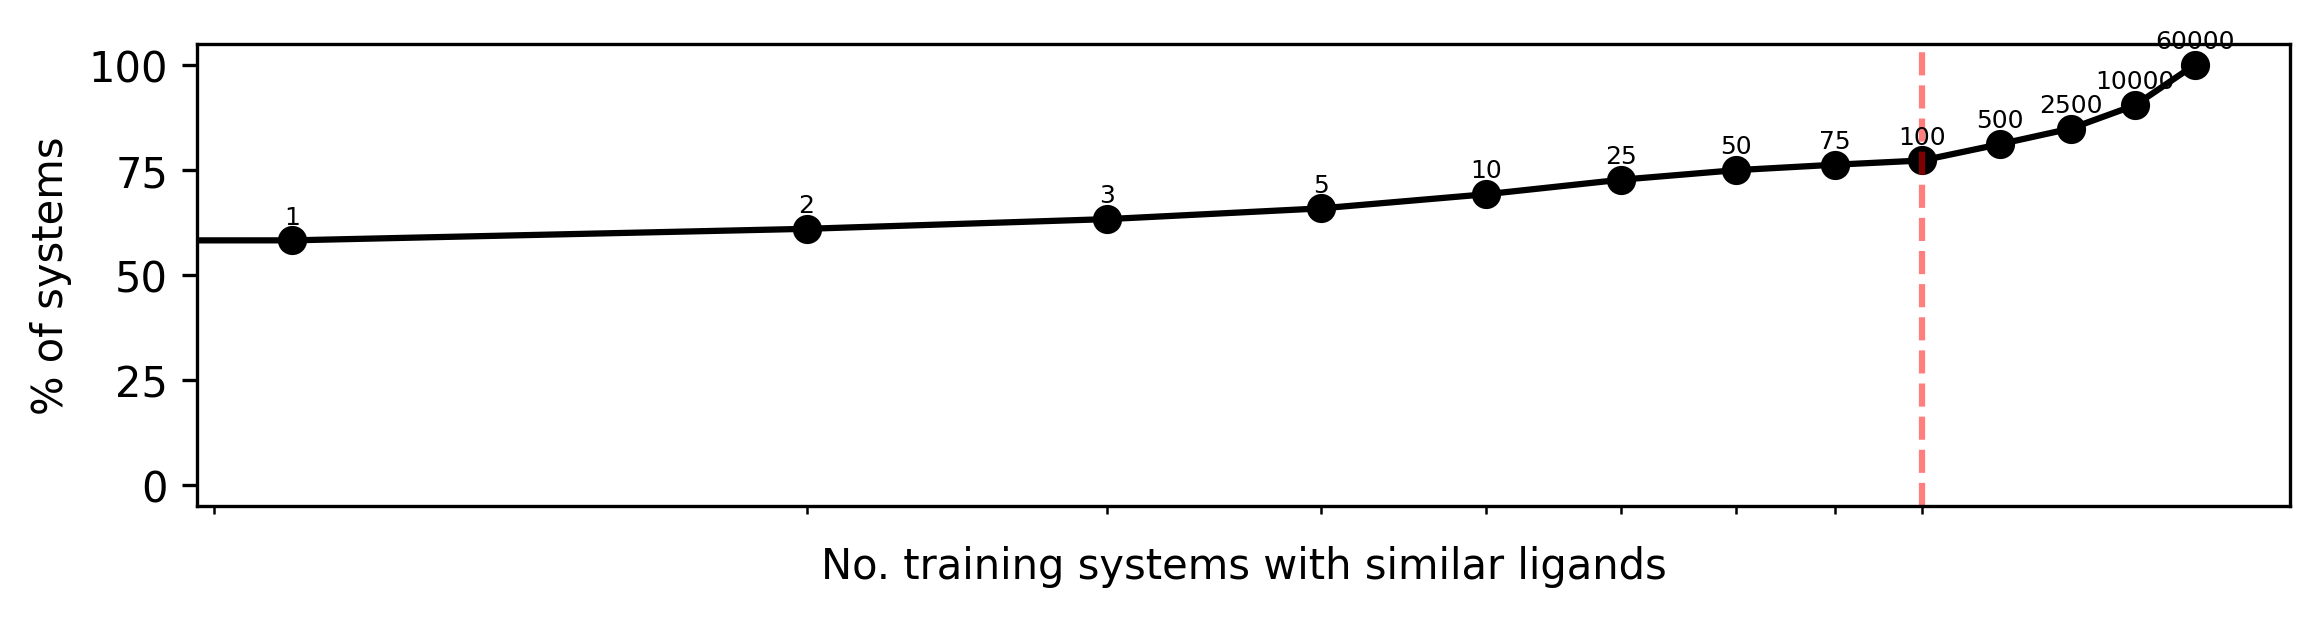

In [11]:
plt.figure(figsize=(9, 2), dpi=300)
cutoffs = [
    0,
    1,
    2,
    3,
    5,
    10,
    25,
    50,
    75,
    100,
    500,
    2500,
    10000,
    60000,
]
counts = []
for cutoff in cutoffs:
    count = (
        common_subset_dfs_all["top"][
            common_subset_dfs_all["top"]["ligand_is_proper"]
            & (common_subset_dfs_all["top"]["sucos_shape"].notna())
        ].drop_duplicates("system_id")["num_training_systems_with_similar_ccds"]
        < cutoff
    ).mean() * 100
    counts.append(count)

plt.plot(range(len(cutoffs)), counts, "o-", color="black")

for i, (cutoff, count) in enumerate(zip(cutoffs, counts)):
    plt.annotate(
        str(cutoff),
        (i, count),
        textcoords="offset points",
        xytext=(0, 4),
        ha="center",
        fontsize=6,
    )

idx_100 = cutoffs.index(100)
plt.axvline(x=idx_100, color="red", linestyle="--", alpha=0.5)

plt.xscale("log")
plt.xticks([], [])
plt.xlabel("No. training systems with similar ligands")
plt.ylabel("% of systems")
plt.savefig(figures_dir / "cofactors_1.png", dpi=300)

## Supplementary Figure 1-2

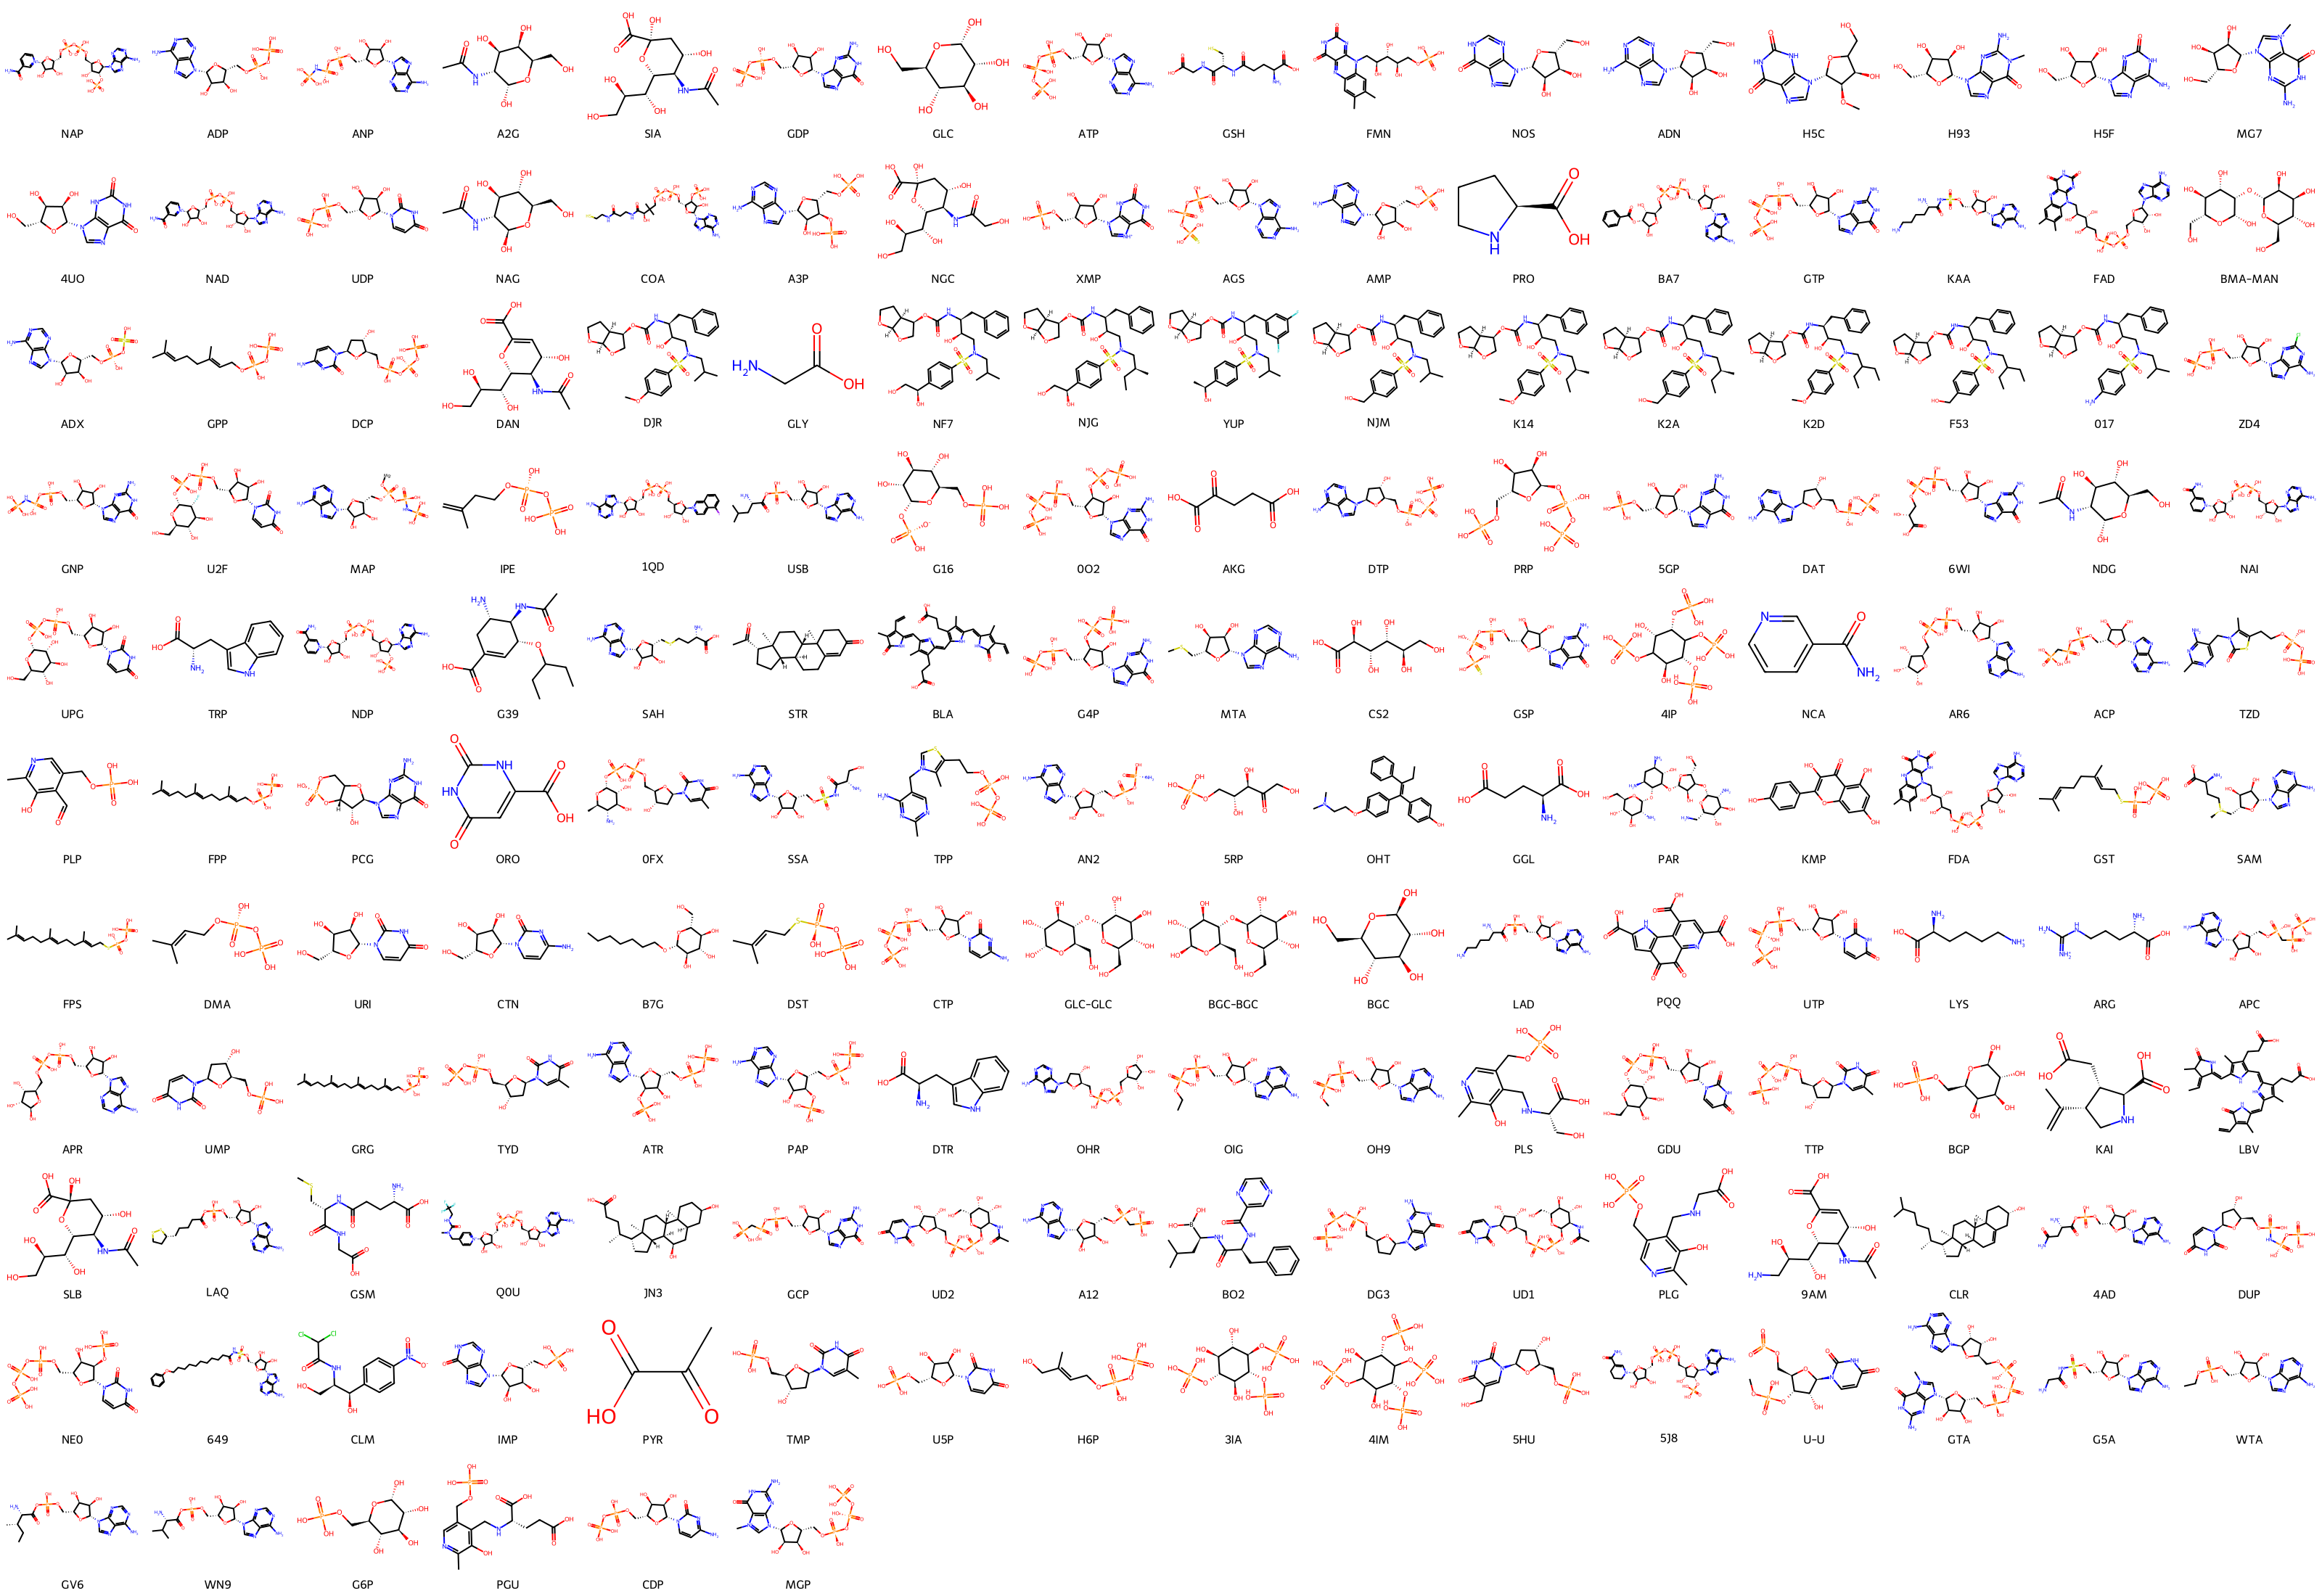

In [12]:
mask = (
    (
        common_subset_dfs_all["top"]["num_training_systems_with_similar_ccds"]
        > NUM_CCDS_THRESHOLD
    )
    & (common_subset_dfs_all["top"]["ligand_is_proper"])
    & (common_subset_dfs_all["top"]["sucos_shape"].notna())
)
smiles_100 = dict(
    zip(
        common_subset_dfs_all["top"][mask]["ligand_ccd_code"],
        common_subset_dfs_all["top"][mask]["ligand_smiles"],
    )
)
molecules_100 = [Chem.MolFromSmiles(smiles) for smiles in smiles_100.values()]
labels_100 = [code for code in smiles_100.keys()]

image = DrawMolsZoomed(
    molecules_100,
    molsPerRow=16,
    subImgSize=(200, 200),
    legends=labels_100,
)
image.save(figures_dir / "cofactors_2.png")
image

## Supplementary Figure 2

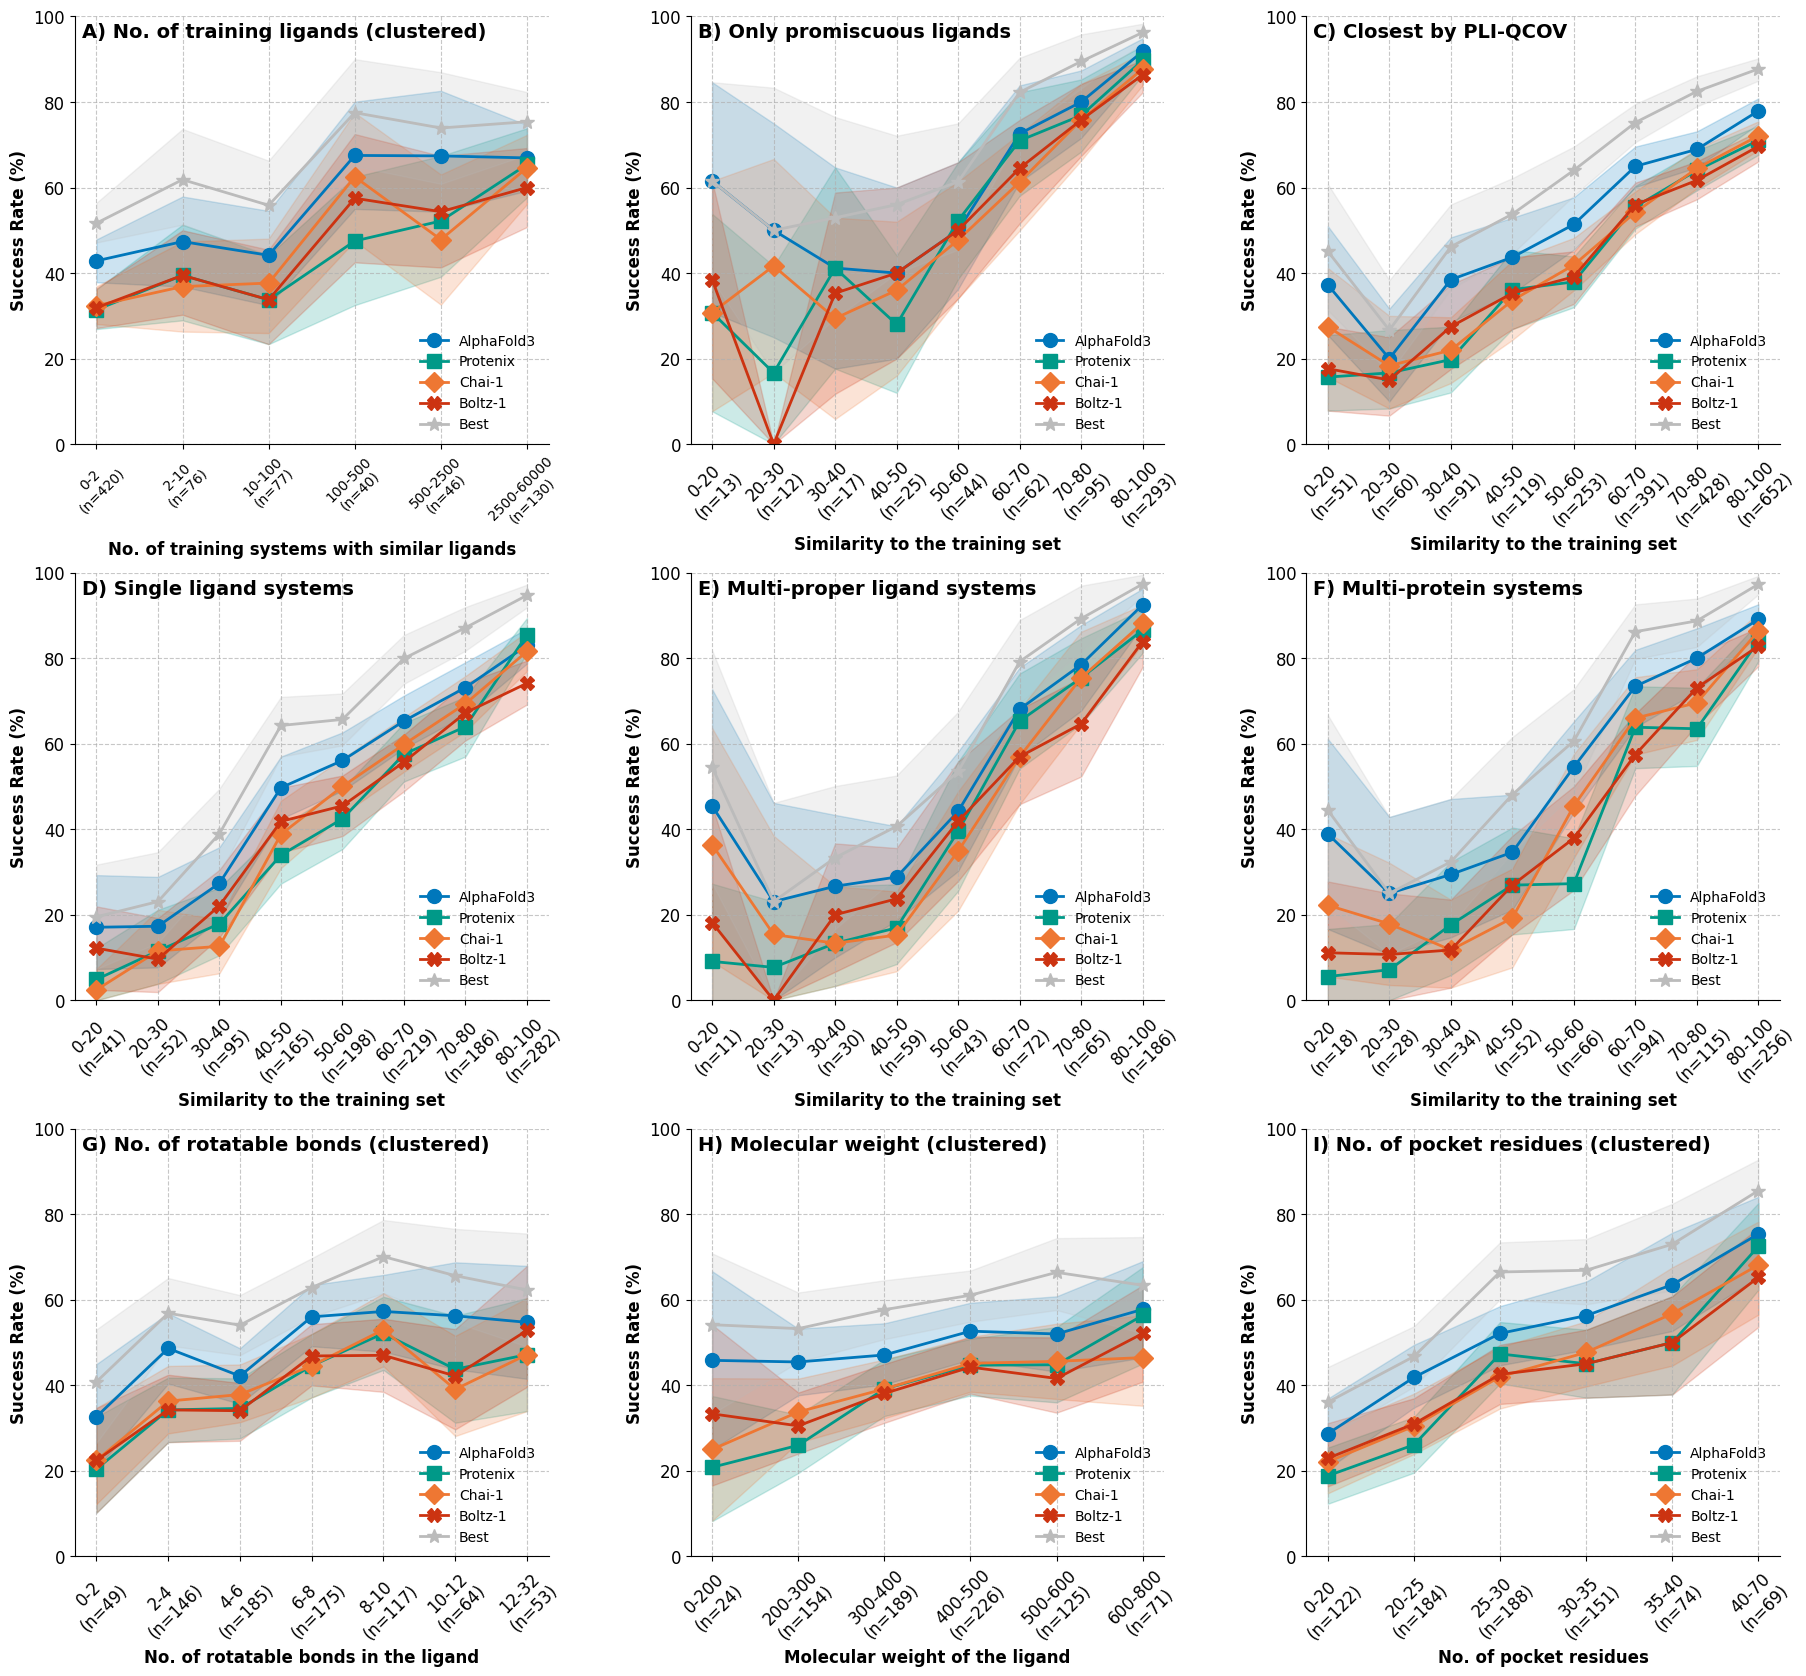

In [13]:
fig = plt.figure(figsize=(22, 20))
gs = plt.GridSpec(
    3,
    3,
    hspace=0.3,
    wspace=0.3,
)
axs = []
for i in range(3):
    for j in range(3):
        axs.append(fig.add_subplot(gs[i, j]))


make_one_plot_binned(
    cluster_dfs_all["top"],
    axs[0],
    "A) No. of training ligands (clustered)",
    "num_training_systems_with_similar_ccds",
    [0, 2, 10, 100, 500, 2500, 60000],
    "No. of training systems with similar ligands",
    fontsize=10,
)
make_one_plot(
    common_subset_dfs_all["top"][
        common_subset_dfs_all["top"]["num_training_systems_with_similar_ccds"]
        >= NUM_CCDS_THRESHOLD
    ],
    ax=axs[1],
    title="B) Only promiscuous ligands",
)
make_one_plot(
    common_subset_dfs_all["top"],
    ax=axs[2],
    title="C) Closest by PLI-QCOV",
    similarity_metric="pli_qcov_pli_qcov",
)
make_one_plot(
    common_subset_dfs_all["top"][
        (common_subset_dfs_all["top"]["num_ligand_chains"] == 1)
    ],
    ax=axs[3],
    title="D) Single ligand systems",
)
make_one_plot(
    common_subset_dfs_all["top"][
        (common_subset_dfs_all["top"]["num_proper_ligand_chains"] > 1)
    ],
    ax=axs[4],
    title="E) Multi-proper ligand systems",
)
make_one_plot(
    common_subset_dfs_all["top"][
        (common_subset_dfs_all["top"]["num_protein_chains"] > 1)
    ],
    ax=axs[5],
    title="F) Multi-protein systems",
)
make_one_plot_binned(
    cluster_dfs_all["top"],
    axs[6],
    "G) No. of rotatable bonds (clustered)",
    "ligand_num_rot_bonds",
    [0, 2, 4, 6, 8, 10, 12, 32],
    "No. of rotatable bonds in the ligand",
)
make_one_plot_binned(
    cluster_dfs_all["top"],
    axs[7],
    "H) Molecular weight (clustered)",
    "ligand_molecular_weight",
    [0, 200, 300, 400, 500, 600, 800],
    "Molecular weight of the ligand",
)

make_one_plot_binned(
    cluster_dfs_all["top"],
    axs[8],
    "I) No. of pocket residues (clustered)",
    "ligand_num_pocket_residues",
    [0, 20, 25, 30, 35, 40, 70],
    "No. of pocket residues",
)

plt.savefig(figures_dir / "stratifications.png", dpi=300)

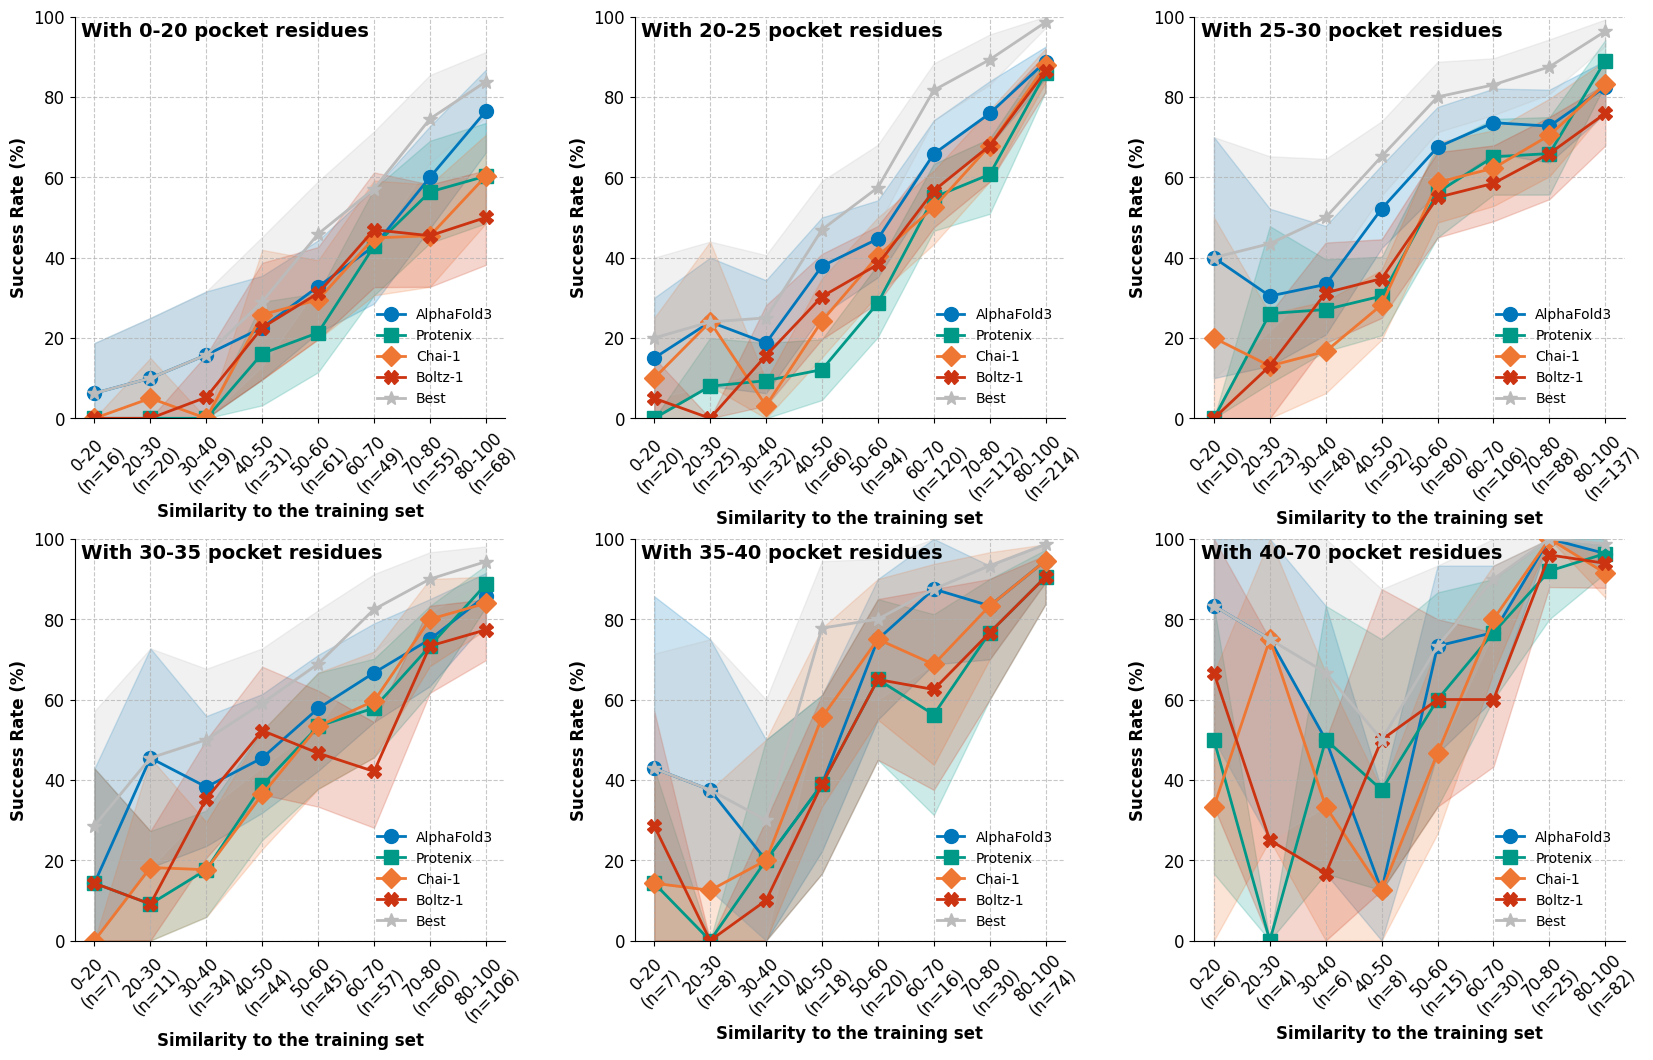

In [14]:
fig = plt.figure(figsize=(20, 12))
gs = plt.GridSpec(
    2,
    3,
    hspace=0.3,
    wspace=0.3,
)
axs = []
for i in range(2):
    for j in range(3):
        axs.append(fig.add_subplot(gs[i, j]))
bins = [0, 20, 25, 30, 35, 40, 70]
for i in range(len(bins) - 1):
    make_one_plot(
        common_subset_dfs_all["top"][
            (common_subset_dfs_all["top"]["ligand_num_pocket_residues"] >= bins[i])
            & (common_subset_dfs_all["top"]["ligand_num_pocket_residues"] < bins[i + 1])
        ],
        axs[i],
        title=f"With {bins[i]}-{bins[i + 1]} pocket residues",
    )
plt.savefig(figures_dir / "pocket_residues.png", dpi=300)

## Supplementary Table 1

In [15]:
SIMILARITY_BIN_LABELS = [
    f"{SIMILARITY_BINS[i]}-{SIMILARITY_BINS[i + 1]}"
    for i in range(len(SIMILARITY_BINS) - 1)
]
annotated_df_clean = annotated_df[
    annotated_df["ligand_is_proper"] & (annotated_df["sucos_shape"].notna())
].reset_index(drop=True)
annotated_df_clean["similarity_bin"] = pd.cut(
    annotated_df_clean[SIMILARITY_METRIC].fillna(0),
    bins=SIMILARITY_BINS,
    labels=SIMILARITY_BIN_LABELS,
    include_lowest=True,
)
annotated_df_clean["cluster_size"] = annotated_df_clean.groupby("cluster")[
    "group_key"
].transform("nunique")
labels = {}
for group, values in annotated_df_clean.groupby("cluster")["similarity_bin"]:
    labels[group] = ", ".join(
        f"{bin} ({count})" for bin, count in values.value_counts().items() if count > 0
    )
annotated_df_clean["cluster_similarity_bins"] = annotated_df_clean["cluster"].map(
    labels
)
print(" & ".join(["Cluster size", "PDB ID", "Keywords", "Similarity bins"]) + " \\\\")
for _, c in (
    annotated_df_clean.sort_values(SIMILARITY_METRIC)
    .groupby("cluster")
    .head(1)
    .sort_values("cluster_size", ascending=False)
    .head(10)[
        [
            "cluster",
            "cluster_size",
            "group_key",
            "entry_keywords",
            "cluster_similarity_bins",
        ]
    ]
).iterrows():
    print(
        " & ".join(
            [
                str(int(c.cluster_size)),
                c.group_key[:4].upper(),
                c.entry_keywords,
                c.cluster_similarity_bins,
            ]
        )
        + " \\\\"
        + "\n\\midrule\n"
    )


Cluster size & PDB ID & Keywords & Similarity bins \\
171 & 7EN9 & VIRAL PROTEIN & 80-100 (79), 70-80 (46), 60-70 (25), 50-60 (15), 40-50 (6) \\
\midrule

136 & 8OKU & SIGNALING PROTEIN & 60-70 (38), 70-80 (37), 80-100 (28), 50-60 (19), 40-50 (11), 30-40 (3) \\
\midrule

100 & 5SH0 & HYDROLASE/HYDROLASE inhibitor & 50-60 (33), 40-50 (26), 30-40 (16), 60-70 (13), 80-100 (5), 20-30 (4), 70-80 (3) \\
\midrule

92 & 8HUU & VIRAL PROTEIN & 80-100 (43), 60-70 (20), 70-80 (20), 40-50 (5), 50-60 (4) \\
\midrule

73 & 7S3Z & OXIDOREDUCTASE/Inhibitor & 80-100 (51), 70-80 (16), 60-70 (5), 50-60 (1) \\
\midrule

43 & 8JOO & OXIDOREDUCTASE & 80-100 (23), 60-70 (5), 70-80 (5), 30-40 (4), 40-50 (3), 50-60 (3) \\
\midrule

35 & 7G00 & LIPID BINDING PROTEIN & 60-70 (13), 50-60 (10), 40-50 (6), 70-80 (3), 80-100 (2), 30-40 (1) \\
\midrule

28 & 7UBO & TRANSCRIPTION/INHIBITOR & 70-80 (7), 80-100 (7), 50-60 (6), 60-70 (5), 40-50 (2), 30-40 (1) \\
\midrule

28 & 7S1S & TRANSFERASE/INHIBITOR & 80-100 (12), 

## Supplementary Figure 3

/scratch/durair0000/slurm-job.29116641/ipykernel_847329/1099935287.py:412: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels([f"{10**x:.2f}" for x in ax4.get_yticks()])


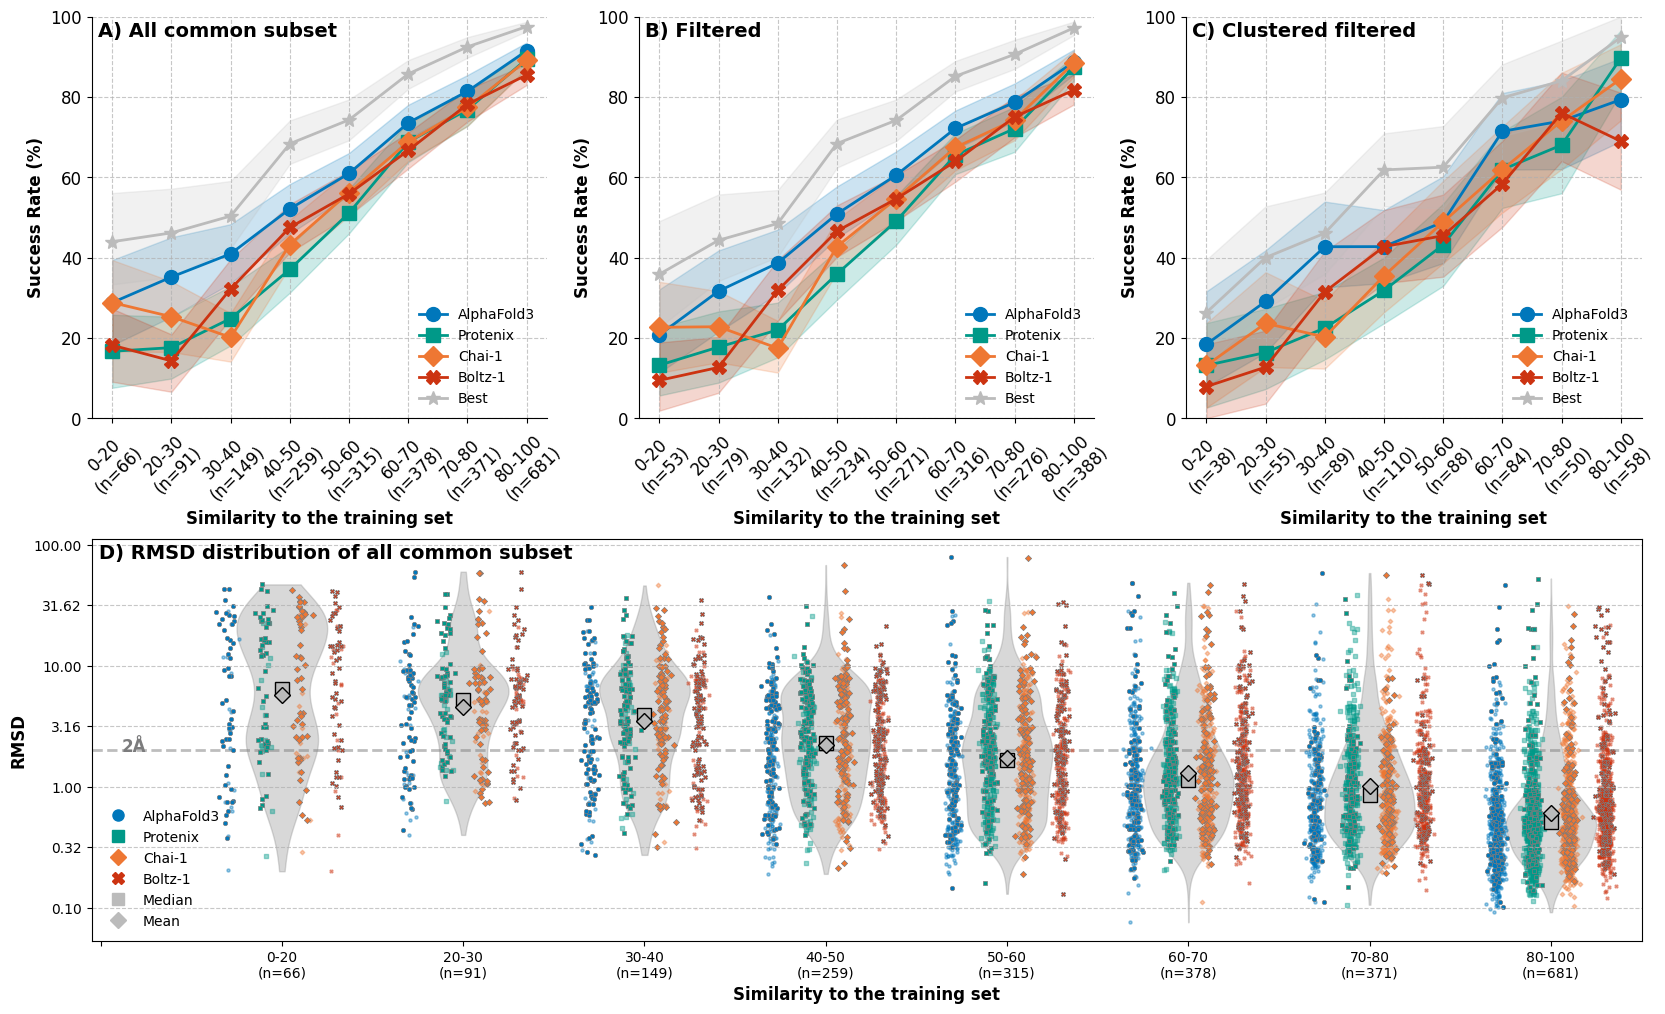

In [16]:
make_main_figure(
    common_subset_dfs_all["top"],
    cluster_dfs_all["top"],
    "fig_1_rmsd.png",
    "rmsd",
    log=True,
    lddt_pli_threshold=0,
    methods=METHODS,
)

## Figure 2

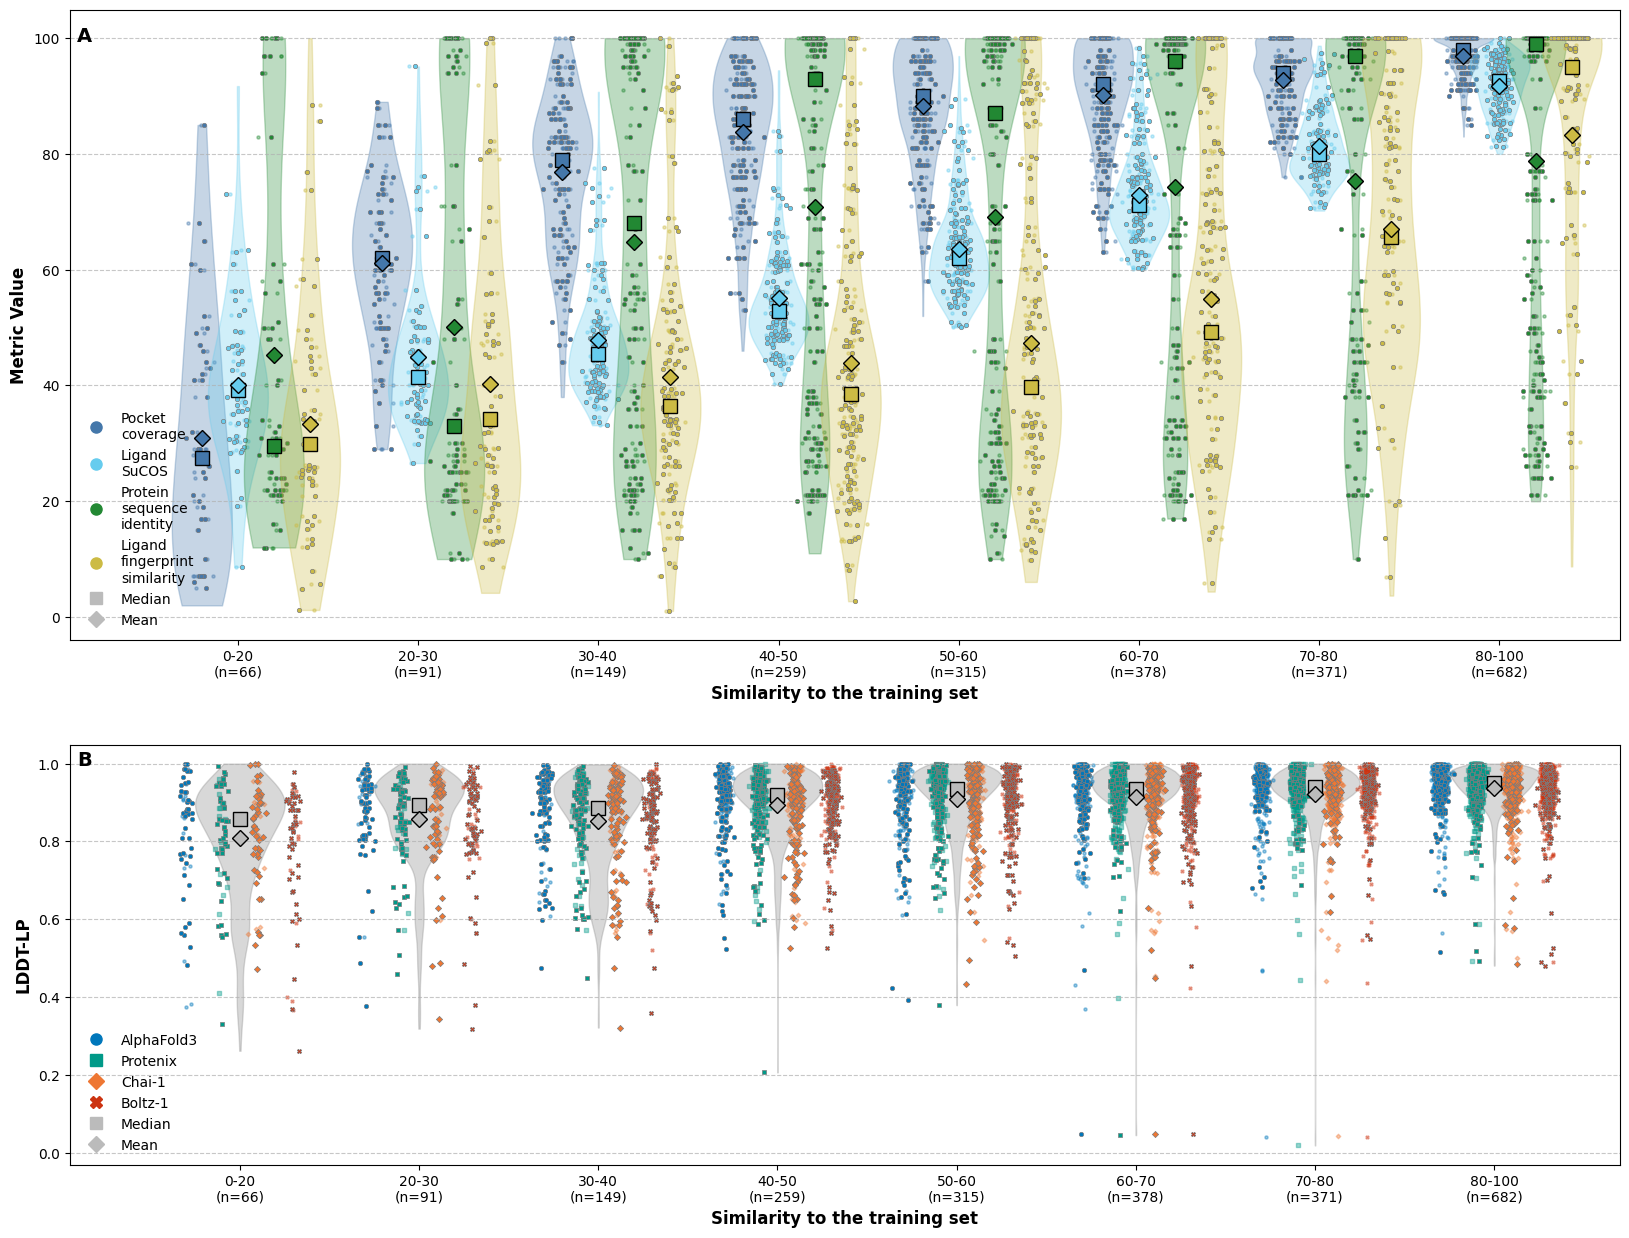

In [17]:
other_metrics(common_subset_dfs_all["top"], cluster_dfs_all["top"], "other_metrics.png")

In [18]:
print("Percentage of systems with LDDT-LP > 0.8, for all systems: ")
print(
    ", ".join(
        f"{NAME_MAPPING[method]}: {(common_subset_dfs_all['top'][common_subset_dfs_all['top']['ligand_is_proper'] & (common_subset_dfs_all['top']['sucos_shape'].notna())][f'lddt_lp_{method}'] > 0.8).mean() * 100:.0f}%"
        for method in METHODS
    )
)
print("For cluster representatives (gray outlines):")
print(
    ", ".join(
        f"{NAME_MAPPING[method]}: {(cluster_dfs_all['top'][cluster_dfs_all['top']['ligand_is_proper'] & (cluster_dfs_all['top']['sucos_shape'].notna())][f'lddt_lp_{method}'] > 0.8).mean() * 100:.0f}%"
        for method in METHODS
    )
)

Percentage of systems with LDDT-LP > 0.8, for all systems: 
AlphaFold3: 92%, Protenix: 91%, Chai-1: 90%, Boltz-1: 90%
For cluster representatives (gray outlines):
AlphaFold3: 87%, Protenix: 83%, Chai-1: 82%, Boltz-1: 83%


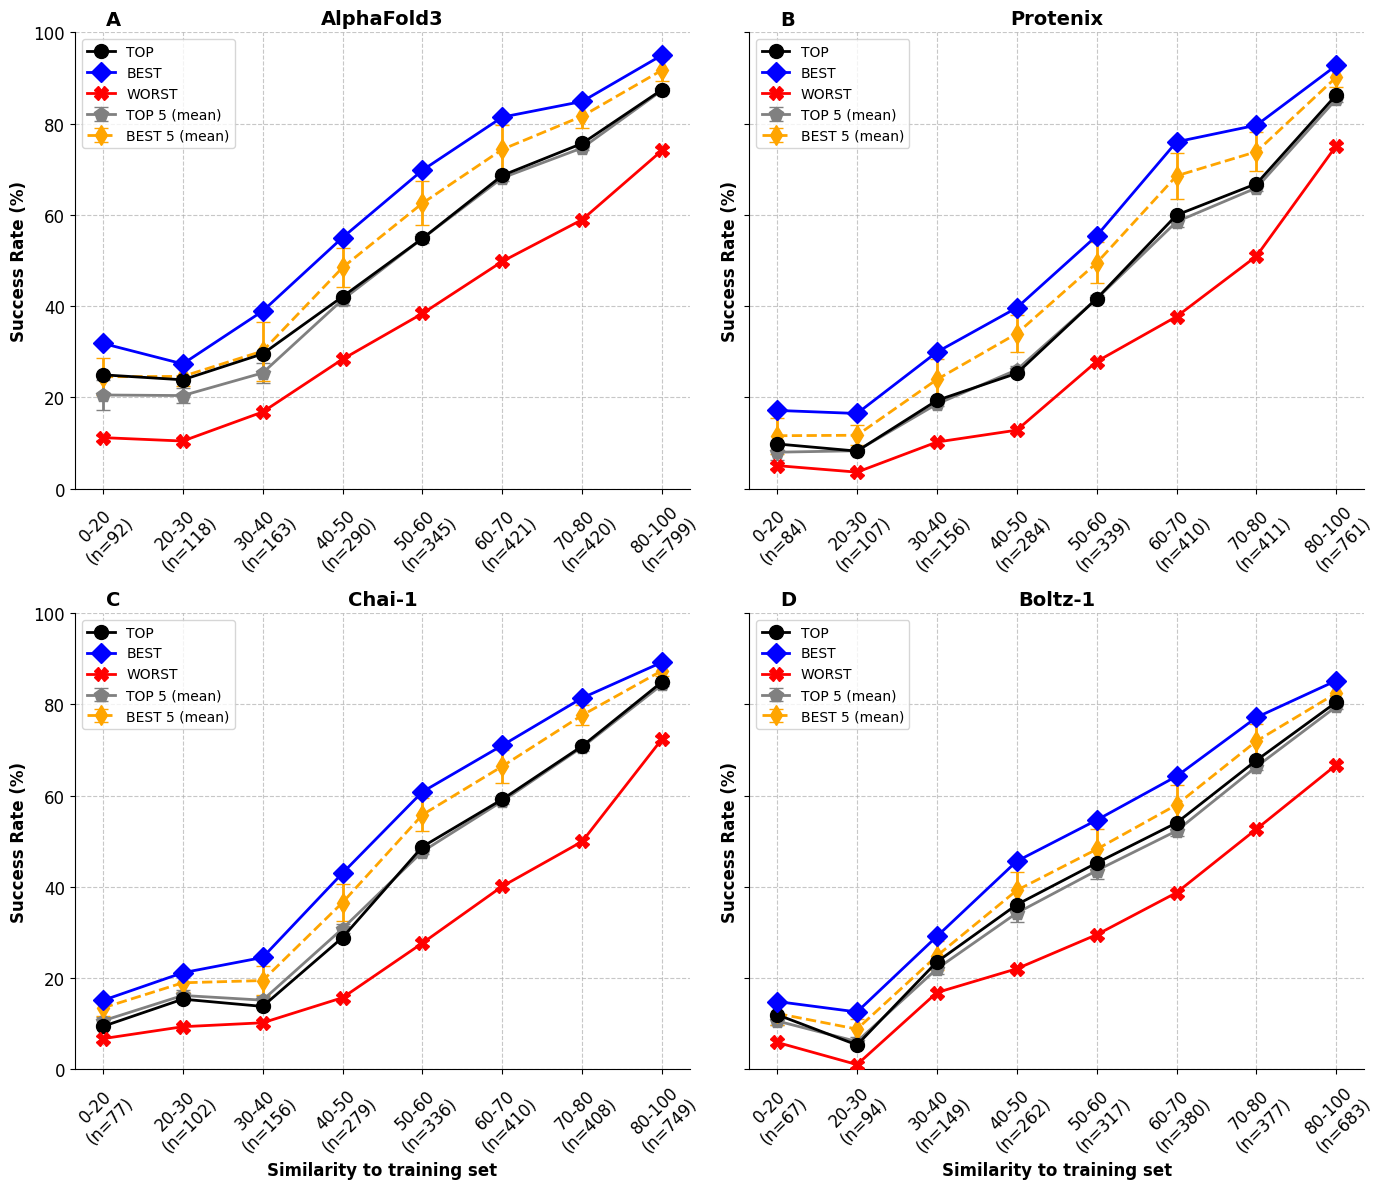

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12), sharey=True)
axs = axs.flatten()
colors = {
    "top": "black",
    "best": "blue",
    "worst": "red",
    "top_5": "gray",
    "best_5": "orange",
}
shapes = {
    "top": "o",
    "best": "D",
    "worst": "X",
    "top_5": "p",
    "best_5": "d",
}


def bootstrap_success_rate(data, n_bootstrap=100):
    if len(data) == 0:
        return 0, 0
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample) * 100)
    return np.mean(bootstrap_means), np.std(bootstrap_means)


labels = "ABCDEF"
for m, method in enumerate(METHODS):
    ax = axs[m]

    label = labels[m]
    ax.text(
        0.05,
        1.05,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
    )

    bin_data = defaultdict(list)
    bin_sizes = defaultdict(list)
    bin_errors = defaultdict(list)

    for df_name in dfs:
        chosen_df = dfs[df_name][
            dfs[df_name]["sucos_shape"].notna() & dfs[df_name]["ligand_is_proper"]
        ]
        for i in range(len(SIMILARITY_BINS) - 1):
            mask = (chosen_df[SIMILARITY_METRIC] >= SIMILARITY_BINS[i]) & (
                chosen_df[SIMILARITY_METRIC] < SIMILARITY_BINS[i + 1]
            )

            mask_inner = mask & (chosen_df[f"rmsd_{method}"].notna())
            bin_sizes[df_name].append(len(chosen_df[mask_inner]))
            success = (chosen_df[mask_inner][f"rmsd_{method}"] < RMSD_THRESHOLD) & (
                chosen_df[mask_inner][f"lddt_pli_{method}"] > LDDT_PLI_THRESHOLD
            )
            mean, std = bootstrap_success_rate(success)
            bin_data[df_name].append(mean)
            bin_errors[df_name].append(std)

    x = np.arange(len(bin_sizes["top"]))

    top_5_means = np.array([bin_data[f"top_5_{i + 1}"] for i in range(5)])
    top_5_mean = np.mean(top_5_means, axis=0)
    top_5_std = np.std(top_5_means, axis=0)
    ax.errorbar(
        x,
        top_5_mean,
        yerr=top_5_std,
        marker=shapes["top_5"],
        markersize=10,
        linestyle="-",
        linewidth=2,
        label="TOP 5 (mean)",
        color=colors["top_5"],
        capsize=5,
    )

    best_5_means = np.array([bin_data[f"best_5_{i + 1}"] for i in range(5)])
    best_5_mean = np.mean(best_5_means, axis=0)
    best_5_std = np.std(best_5_means, axis=0)
    ax.errorbar(
        x,
        best_5_mean,
        yerr=best_5_std,
        marker=shapes["best_5"],
        markersize=10,
        linestyle="--",
        linewidth=2,
        label="BEST 5 (mean)",
        color=colors["best_5"],
        capsize=5,
    )

    for df_name in ["top", "best", "worst"]:
        ax.plot(
            x,
            bin_data[df_name],
            marker=shapes[df_name],
            markersize=10,
            linestyle="-",
            linewidth=2,
            label=df_name.upper(),
            color=colors[df_name],
            zorder=10,
        )
        # ax.fill_between(
        #     x,
        #     np.array(bin_data[df_name]) - np.array(bin_errors[df_name]),
        #     np.array(bin_data[df_name]) + np.array(bin_errors[df_name]),
        #     alpha=0.2,
        #     color=colors[df_name],
        # )

    if m > 1:
        ax.set_xlabel("Similarity to training set", fontsize=12, fontweight="bold")
    ax.set_ylabel("Success Rate (%)", fontsize=12, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(
        [
            f"{SIMILARITY_BINS[i]}-{SIMILARITY_BINS[i + 1]}\n(n={bin_sizes['top'][i]:,})"
            for i in range(len(SIMILARITY_BINS) - 1)
        ],
        rotation=45,
        fontsize=12,
    )
    ax.set_ylim(0, 100)
    ax.tick_params(axis="y", labelsize=12)

    ax.grid(True, linestyle="--", alpha=0.7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(NAME_MAPPING[method], fontsize=14, fontweight="bold")
    legend = ax.legend(loc="upper left", fontsize=10)

plt.tight_layout()
plt.savefig(figures_dir / "confidence.png", dpi=300)

# Methods

## Figure 5

/scratch/durair0000/slurm-job.29116641/ipykernel_847329/1719553850.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_datasets[method][full_datasets[method]["ligand_is_proper"].fillna(False)][
/scratch/durair0000/slurm-job.29116641/ipykernel_847329/1719553850.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_datasets[method][full_datasets[method]["ligand_is_proper"].fillna(False)][
/scratch/durair0000/slurm-job.29116641/ipykernel_847329/1719553850.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated

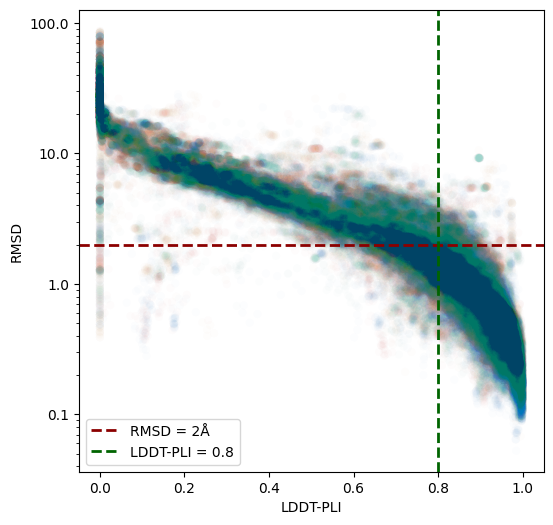

In [20]:
all_lddt_plis = []
all_rmsds = []
colors = []
for method in METHODS[::-1]:
    all_lddt_plis.extend(
        full_datasets[method][full_datasets[method]["ligand_is_proper"].fillna(False)][
            "lddt_pli"
        ].dropna()
    )
    all_rmsds.extend(
        full_datasets[method][full_datasets[method]["ligand_is_proper"].fillna(False)][
            "rmsd"
        ].dropna()
    )
    colors.extend(
        [COLORS[method]]
        * len(
            full_datasets[method][
                full_datasets[method]["ligand_is_proper"].fillna(False)
            ]["lddt_pli"].dropna()
        )
    )
all_lddt_plis = np.array(all_lddt_plis)
all_rmsds = np.array(all_rmsds)

plt.figure(figsize=(6, 6))
plt.scatter(all_lddt_plis, all_rmsds, c=colors, alpha=0.01, linewidths=0)
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))
plt.xlabel("LDDT-PLI")
plt.ylabel("RMSD")

plt.axhline(
    y=RMSD_THRESHOLD,
    color="darkred",
    linestyle="--",
    alpha=1,
    label="RMSD = 2Å",
    linewidth=2,
)
plt.axvline(
    x=LDDT_PLI_THRESHOLD,
    color="darkgreen",
    linestyle="--",
    alpha=1,
    label="LDDT-PLI = 0.8",
    linewidth=2,
)
plt.legend()
plt.savefig(figures_dir / "rmsd_lddt.png", dpi=300)

In [21]:
print(
    "Percentage of systems with RMSD < 2Å and LDDT-PLI > 0.8: ",
    100
    * all_lddt_plis[
        (all_rmsds < RMSD_THRESHOLD) & (all_lddt_plis < LDDT_PLI_THRESHOLD)
    ].shape[0]
    / all_lddt_plis.shape[0],
)
print(
    "Percentage of systems with RMSD > 2Å and LDDT-PLI > 0.8: ",
    100
    * all_lddt_plis[
        (all_rmsds > RMSD_THRESHOLD) & (all_lddt_plis > LDDT_PLI_THRESHOLD)
    ].shape[0]
    / all_lddt_plis.shape[0],
)

Percentage of systems with RMSD < 2Å and LDDT-PLI > 0.8:  8.35856841107843
Percentage of systems with RMSD > 2Å and LDDT-PLI > 0.8:  1.5863552914700831


## Figure 6

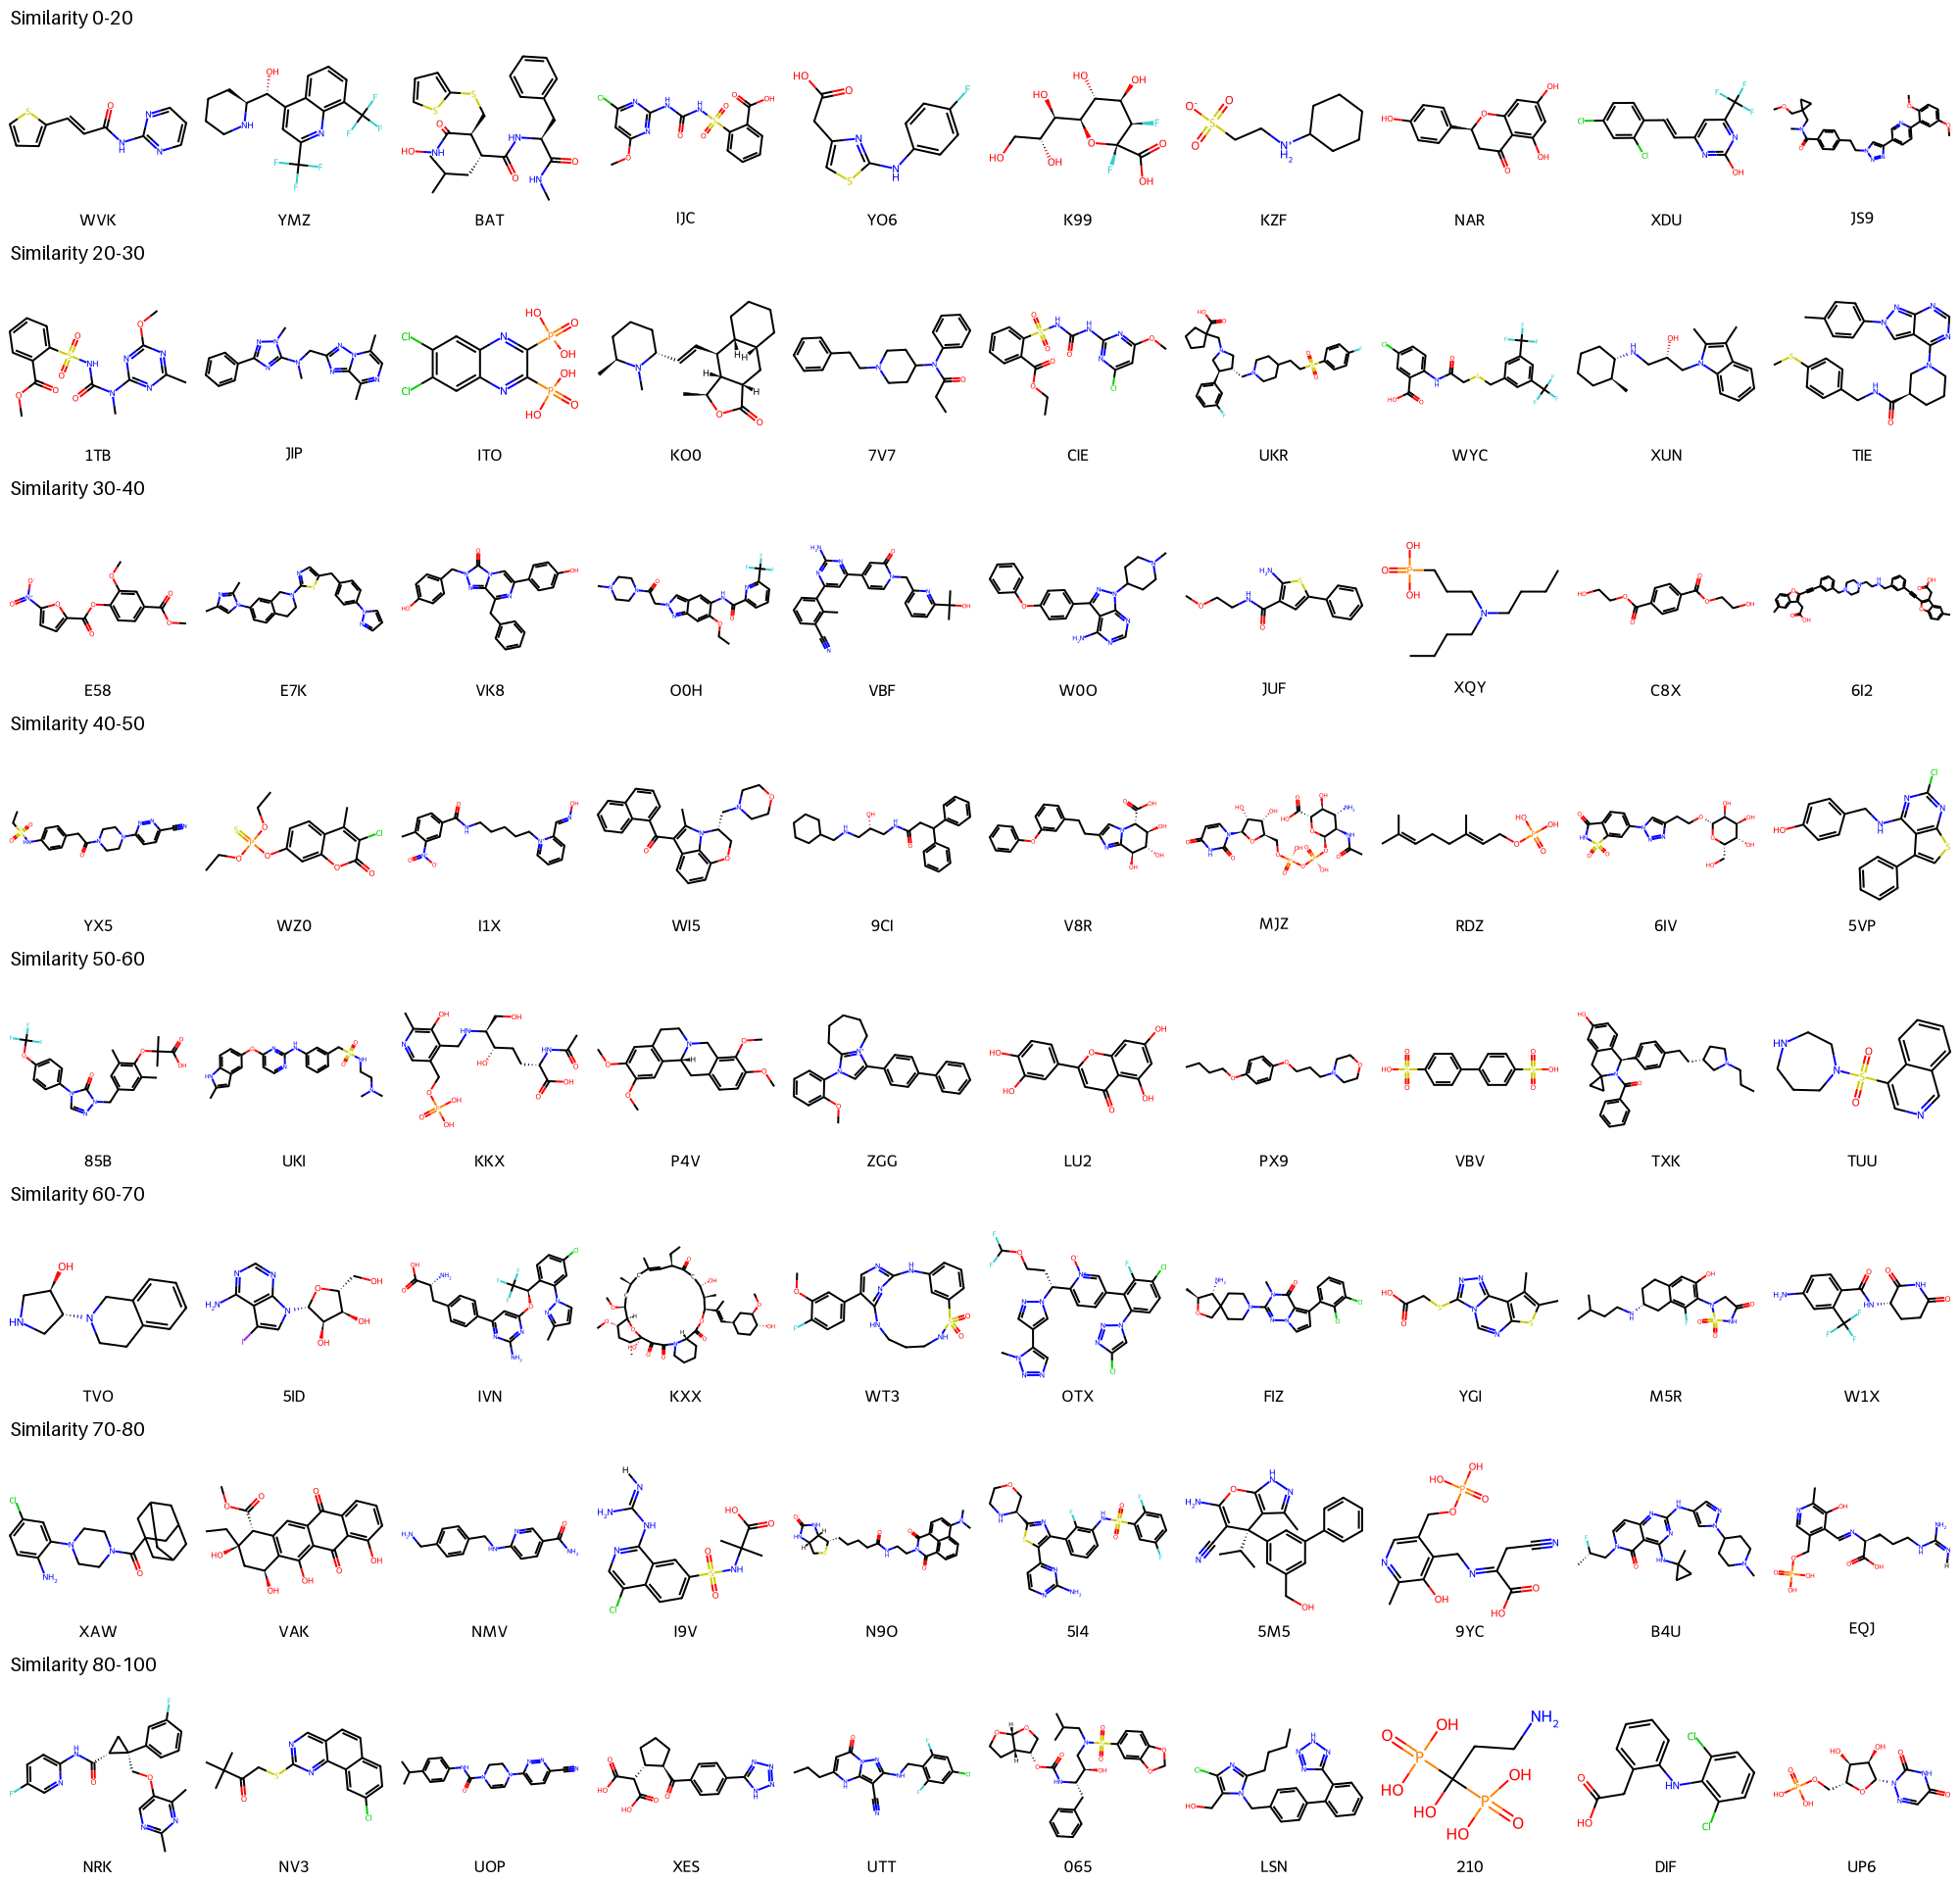

In [22]:
# Get 10 random smiles from each similarity bin
smiles_by_bin = {}
for i in range(len(SIMILARITY_BINS) - 1):
    bin_mask = (
        (cluster_dfs_all["top"][SIMILARITY_METRIC] >= SIMILARITY_BINS[i])
        & (cluster_dfs_all["top"][SIMILARITY_METRIC] <= SIMILARITY_BINS[i + 1])
        & (
            cluster_dfs_all["top"]["num_training_systems_with_similar_ccds"]
            < NUM_CCDS_THRESHOLD
        )
        & (cluster_dfs_all["top"]["ligand_is_proper"])
    )
    bin_df = cluster_dfs_all["top"][bin_mask]
    if len(bin_df) > 0:
        sample_df = bin_df.sample(n=min(10, len(bin_df)))
        smiles_by_bin[f"{SIMILARITY_BINS[i]}-{SIMILARITY_BINS[i + 1]}"] = dict(
            zip(sample_df["ligand_ccd_code"], sample_df["ligand_smiles"])
        )

all_smiles = []
row_labels = []
current_bin = None

for bin_label, bin_smiles in smiles_by_bin.items():
    if bin_smiles:
        row_labels.append(f"Similarity {bin_label}")
        for code, smiles in bin_smiles.items():
            all_smiles.append((code, smiles))

molecules = [Chem.MolFromSmiles(smiles) for _, smiles in all_smiles]
labels = [code for code, _ in all_smiles]

image = DrawMolsZoomed(
    molecules,
    molsPerRow=10,
    subImgSize=(200, 200),
    legends=labels,
    row_labels=row_labels,
)
image.save(figures_dir / "ligands.png")
image

# Appendix

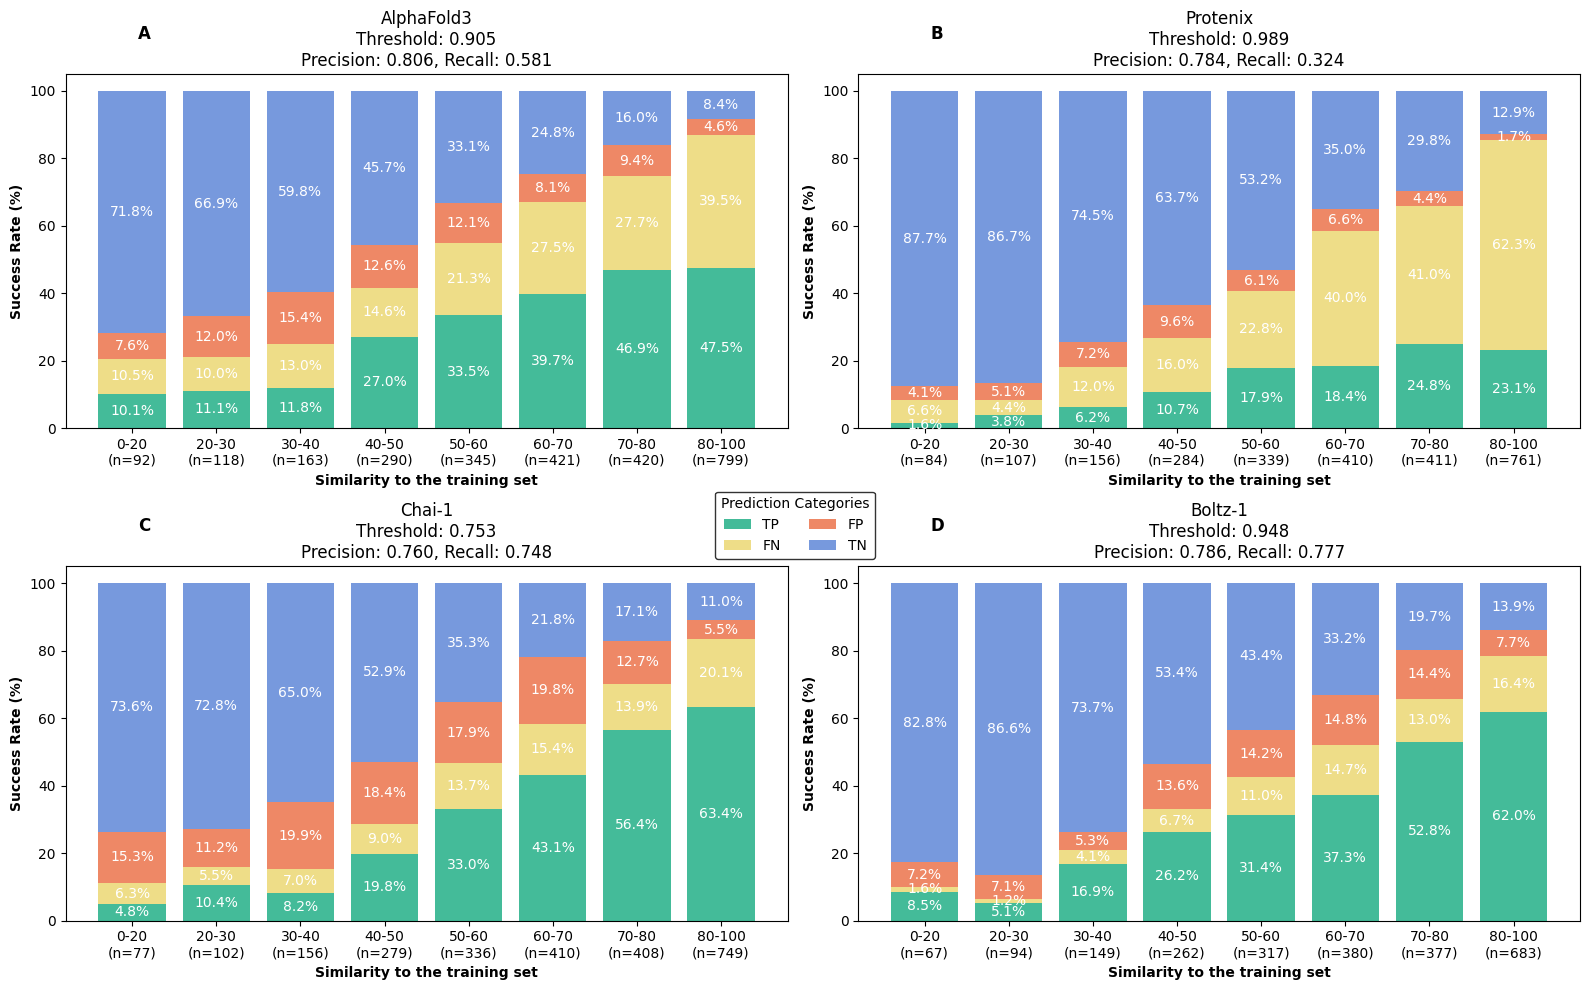

In [23]:
column_name = "lig_prot_chain_iptm_average_rmsd"

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
all_data = {}
for method_idx, method in enumerate(METHODS):
    ax = axes[method_idx]
    ax.text(
        0.1,
        1.1,
        chr(65 + method_idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
    )
    df = full_datasets[method].merge(
        annotated_df,
        on="group_key",
        how="left",
    )
    df = df[df["ligand_is_proper_x"] & (df["sucos_shape"].notna())].reset_index(
        drop=True
    )
    df["success"] = (df["lddt_pli"] > LDDT_PLI_THRESHOLD) & (
        df["rmsd"] < RMSD_THRESHOLD
    )
    y_true = df["success"].astype(int)
    y_scores = df[column_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    confidence_threshold = thresholds[optimal_idx]

    bin_labels = []
    all_data[method] = defaultdict(list)

    for i in range(len(SIMILARITY_BINS) - 1):
        bin_mask = (df[SIMILARITY_METRIC] >= SIMILARITY_BINS[i]) & (
            df[SIMILARITY_METRIC] < SIMILARITY_BINS[i + 1]
        )
        bin_data = df[bin_mask].reset_index(drop=True)
        total = len(df[bin_mask]) if len(df[bin_mask]) > 0 else 1
        bin_labels.append(
            f"{SIMILARITY_BINS[i]}-{SIMILARITY_BINS[i + 1]}\n(n={bin_data['group_key'].nunique():,})"
        )
        all_data[method]["TP"].append(
            100
            * len(
                bin_data[
                    (bin_data[column_name] > confidence_threshold)
                    & (bin_data["success"])
                ]
            )
            / total
        )
        all_data[method]["FN"].append(
            100
            * len(
                bin_data[
                    (bin_data[column_name] <= confidence_threshold)
                    & (bin_data["success"])
                ]
            )
            / total
        )
        all_data[method]["FP"].append(
            100
            * len(
                bin_data[
                    (bin_data[column_name] > confidence_threshold)
                    & (~bin_data["success"])
                ]
            )
            / total
        )
        all_data[method]["TN"].append(
            100
            * len(
                bin_data[
                    (bin_data[column_name] <= confidence_threshold)
                    & (~bin_data["success"])
                ]
            )
            / total
        )

    categories = ["TP", "FN", "FP", "TN"]
    tol_light = list(cmap.Colormap("tol:light").iter_colors())
    colors = [
        tol_light[2],
        tol_light[5],
        tol_light[6],
        tol_light[0],
    ]

    bottom = np.zeros(len(bin_labels))
    for cat, color in zip(categories, colors):
        if method_idx == 0:
            bars = ax.bar(
                bin_labels, all_data[method][cat], color=color, label=cat, bottom=bottom
            )
        else:
            bars = ax.bar(bin_labels, all_data[method][cat], color=color, bottom=bottom)
        for idx, rect in enumerate(bars):
            height = all_data[method][cat][idx]
            if height > 0:
                ax.text(
                    rect.get_x() + rect.get_width() / 2,
                    bottom[idx] + height / 2,
                    f"{height:.1f}%",
                    ha="center",
                    va="center",
                    color="white",
                )
        bottom += all_data[method][cat]

    precision = precision_score(y_true, y_scores > confidence_threshold)
    recall = recall_score(y_true, y_scores > confidence_threshold)

    ax.set_title(
        f"{NAME_MAPPING[method]}\n",
        weight="bold",
    )
    ax.set_title(
        f"{NAME_MAPPING[method]}\n"
        f"Threshold: {confidence_threshold:.3f}\n"
        f"Precision: {precision:.3f}, Recall: {recall:.3f}",
    )
    ax.set_ylabel("Success Rate (%)", fontsize=10, fontweight="bold")
    ax.set_xlabel("Similarity to the training set", fontsize=10, fontweight="bold")

fig.legend(
    loc="center",
    bbox_to_anchor=(0.5, 0.47),
    ncol=2,
    title="Prediction Categories",
    frameon=True,
    edgecolor="black",
)

plt.tight_layout()
plt.savefig(figures_dir / "iptm.png", dpi=300)

In [24]:
i = 0
for method in METHODS:
    print(
        method,
        100
        * all_data[method]["FP"][i]
        / (all_data[method]["TP"][i] + all_data[method]["FP"][i]),
    )

af3 42.966751918158565
protenix 72.03389830508473
chai 76.19047619047619
boltz 45.86776859504132


In [25]:
i = 7
for method in METHODS:
    print(
        method,
        100
        * all_data[method]["FP"][i]
        / (all_data[method]["TP"][i] + all_data[method]["FP"][i]),
    )

af3 8.806790778431562
protenix 6.997455470737912
chai 7.925498753117207
boltz 11.051628708828598


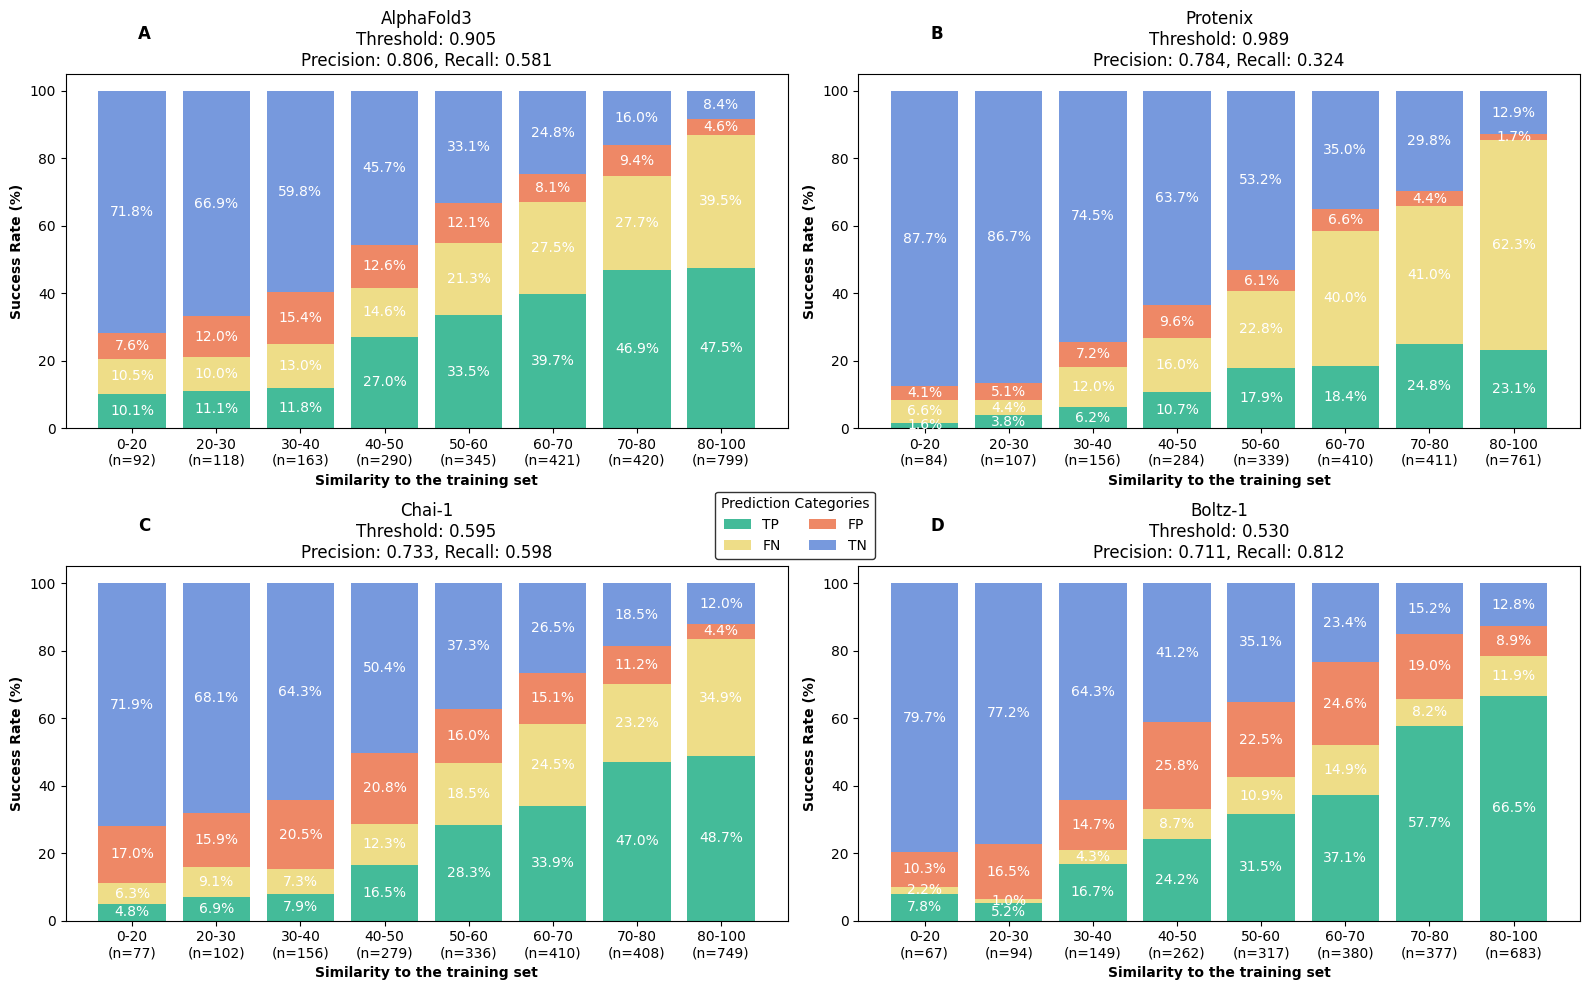

In [26]:
column_name = "prot_lig_chain_iptm_average_rmsd"

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
all_data = {}
for method_idx, method in enumerate(METHODS):
    ax = axes[method_idx]
    ax.text(
        0.1,
        1.1,
        chr(65 + method_idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
    )
    df = full_datasets[method].merge(
        annotated_df,
        on="group_key",
        how="left",
    )
    df = df[df["ligand_is_proper_x"] & (df["sucos_shape"].notna())].reset_index(
        drop=True
    )
    df["success"] = (df["lddt_pli"] > LDDT_PLI_THRESHOLD) & (
        df["rmsd"] < RMSD_THRESHOLD
    )
    y_true = df["success"].astype(int)
    y_scores = df[column_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    confidence_threshold = thresholds[optimal_idx]

    bin_labels = []
    all_data[method] = defaultdict(list)

    for i in range(len(SIMILARITY_BINS) - 1):
        bin_mask = (df[SIMILARITY_METRIC] >= SIMILARITY_BINS[i]) & (
            df[SIMILARITY_METRIC] < SIMILARITY_BINS[i + 1]
        )
        bin_data = df[bin_mask].reset_index(drop=True)
        total = len(df[bin_mask]) if len(df[bin_mask]) > 0 else 1
        bin_labels.append(
            f"{SIMILARITY_BINS[i]}-{SIMILARITY_BINS[i + 1]}\n(n={bin_data['group_key'].nunique():,})"
        )
        all_data[method]["TP"].append(
            100
            * len(
                bin_data[
                    (bin_data[column_name] > confidence_threshold)
                    & (bin_data["success"])
                ]
            )
            / total
        )
        all_data[method]["FN"].append(
            100
            * len(
                bin_data[
                    (bin_data[column_name] <= confidence_threshold)
                    & (bin_data["success"])
                ]
            )
            / total
        )
        all_data[method]["FP"].append(
            100
            * len(
                bin_data[
                    (bin_data[column_name] > confidence_threshold)
                    & (~bin_data["success"])
                ]
            )
            / total
        )
        all_data[method]["TN"].append(
            100
            * len(
                bin_data[
                    (bin_data[column_name] <= confidence_threshold)
                    & (~bin_data["success"])
                ]
            )
            / total
        )

    categories = ["TP", "FN", "FP", "TN"]
    tol_light = list(cmap.Colormap("tol:light").iter_colors())
    colors = [
        tol_light[2],
        tol_light[5],
        tol_light[6],
        tol_light[0],
    ]

    bottom = np.zeros(len(bin_labels))
    for cat, color in zip(categories, colors):
        if method_idx == 0:
            bars = ax.bar(
                bin_labels, all_data[method][cat], color=color, label=cat, bottom=bottom
            )
        else:
            bars = ax.bar(bin_labels, all_data[method][cat], color=color, bottom=bottom)
        for idx, rect in enumerate(bars):
            height = all_data[method][cat][idx]
            if height > 0:
                ax.text(
                    rect.get_x() + rect.get_width() / 2,
                    bottom[idx] + height / 2,
                    f"{height:.1f}%",
                    ha="center",
                    va="center",
                    color="white",
                )
        bottom += all_data[method][cat]

    precision = precision_score(y_true, y_scores > confidence_threshold)
    recall = recall_score(y_true, y_scores > confidence_threshold)

    ax.set_title(
        f"{NAME_MAPPING[method]}\n",
        weight="bold",
    )
    ax.set_title(
        f"{NAME_MAPPING[method]}\n"
        f"Threshold: {confidence_threshold:.3f}\n"
        f"Precision: {precision:.3f}, Recall: {recall:.3f}",
    )
    ax.set_ylabel("Success Rate (%)", fontsize=10, fontweight="bold")
    ax.set_xlabel("Similarity to the training set", fontsize=10, fontweight="bold")

fig.legend(
    loc="center",
    bbox_to_anchor=(0.5, 0.47),
    ncol=2,
    title="Prediction Categories",
    frameon=True,
    edgecolor="black",
)

plt.tight_layout()
plt.savefig(figures_dir / "iptm_reversed.png", dpi=300)

In [27]:
common_subset_dfs_all["top"][
    (common_subset_dfs_all["top"][SIMILARITY_METRIC] > 50)
    & (common_subset_dfs_all["top"]["ligand_is_proper"])
    & (common_subset_dfs_all["top"]["sucos_shape"].notna())
].shape[0] / common_subset_dfs_all["top"][
    common_subset_dfs_all["top"]["ligand_is_proper"]
    & (common_subset_dfs_all["top"]["sucos_shape"].notna())
].shape[0]

0.7555170921678926

In [28]:
for method in METHODS:
    print(method)
    df = dfs["top"][dfs["top"][f"rmsd_{method}"].notna()]
    print("No. PDB IDs:", len(set(df["system_id"].map(lambda x: x[:4]))))
    print("No. systems:", df["system_id"].nunique())
    print(
        "No. ligands (including ions and artifacts):",
        df["system_id"]
        .drop_duplicates()
        .map(lambda x: len(x.split("__")[-1].split("_")))
        .sum(),
    )
    print(
        "No. proper ligands:",
        annotated_df[annotated_df["system_id"].isin(df["system_id"])][
            "ligand_is_proper"
        ].sum(),
    )
    plindex_proper = annotated_df[
        annotated_df["ligand_is_proper"]
        & annotated_df["system_id"].isin(df["system_id"])
    ].reset_index(drop=True)
    print(
        "No. multi-ligand systems:",
        len(
            plindex_proper[plindex_proper.duplicated(subset=["system_id"], keep=False)][
                "system_id"
            ].unique()
        ),
    )
    print(
        "No. multi-protein systems:",
        df["system_id"]
        .drop_duplicates()
        .map(lambda x: len(x.split("__")[2].split("_")) > 1)
        .sum(),
    )
    print()

af3
No. PDB IDs: 2415
No. systems: 2429
No. ligands (including ions and artifacts): 3906
No. proper ligands: 2730
No. multi-ligand systems: 296
No. multi-protein systems: 739

protenix
No. PDB IDs: 2329
No. systems: 2343
No. ligands (including ions and artifacts): 3772
No. proper ligands: 2629
No. multi-ligand systems: 281
No. multi-protein systems: 703

chai
No. PDB IDs: 2300
No. systems: 2313
No. ligands (including ions and artifacts): 3730
No. proper ligands: 2593
No. multi-ligand systems: 275
No. multi-protein systems: 687

boltz
No. PDB IDs: 2145
No. systems: 2159
No. ligands (including ions and artifacts): 3418
No. proper ligands: 2420
No. multi-ligand systems: 256
No. multi-protein systems: 627



## Supplementary Figure all


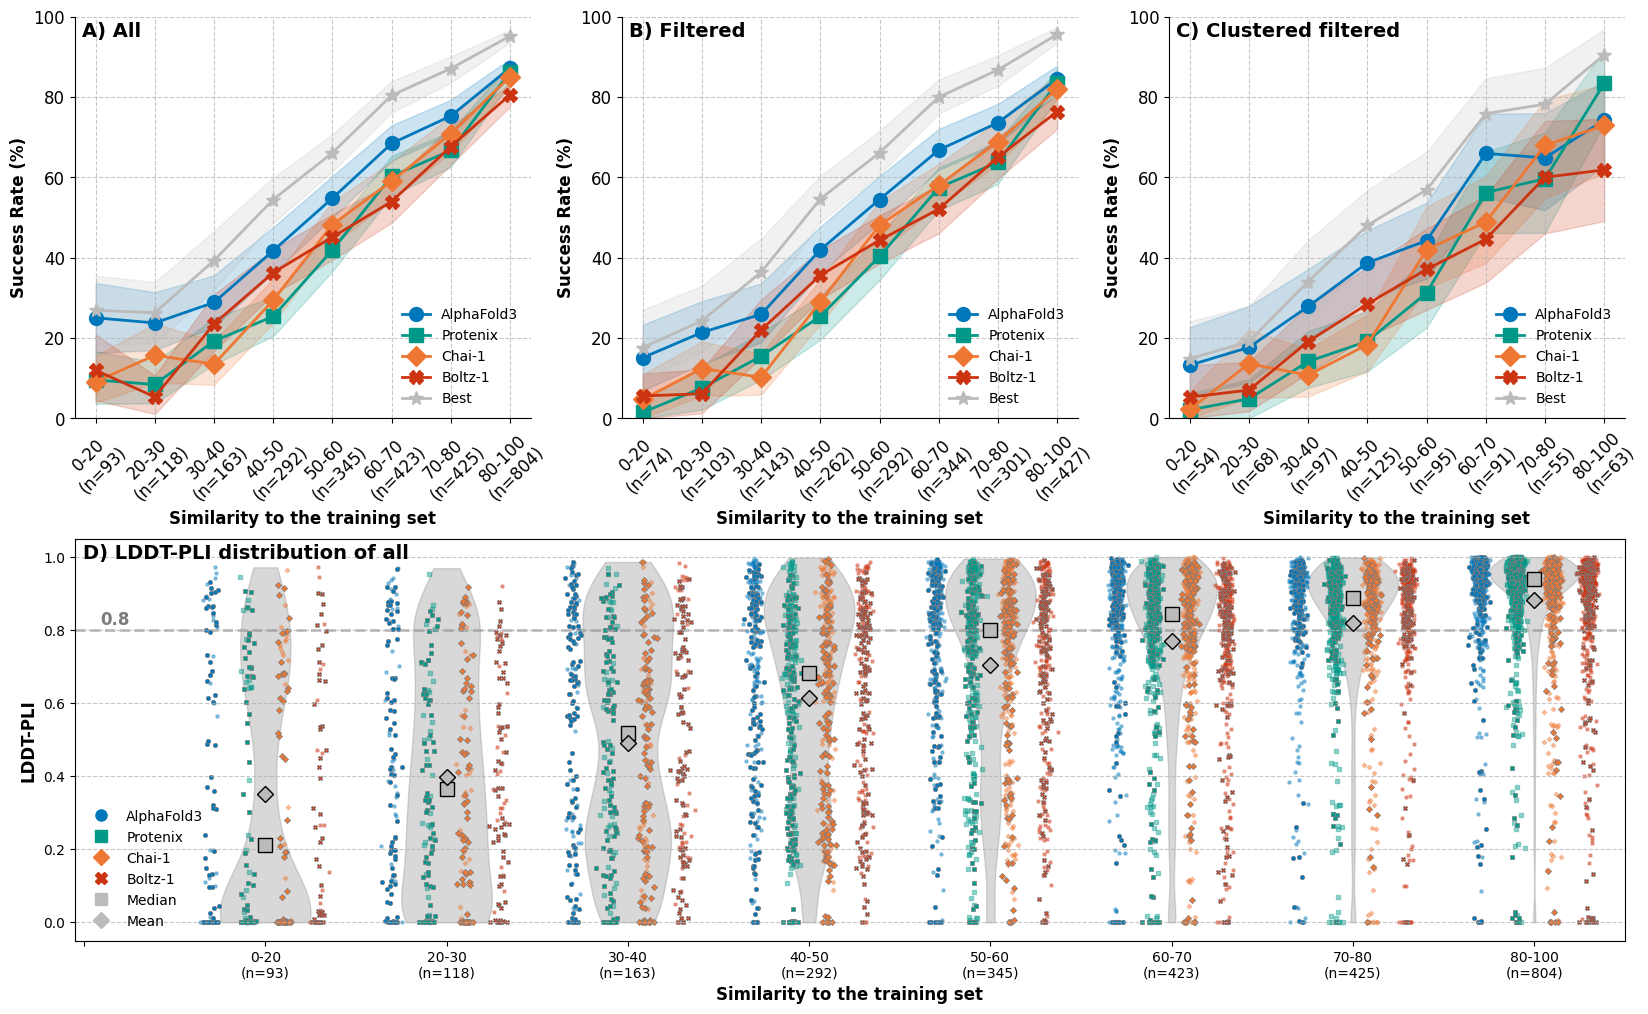

In [29]:
make_main_figure(
    dfs["top"],
    dfs["top"].sort_values(by=SIMILARITY_METRIC).groupby("cluster").head(1),
    "fig_1_all.png",
    "lddt_pli",
    suffix="",
)